In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn import metrics
from category_encoders import TargetEncoder

In [4]:
log_shots = pd.read_csv('shot_logs.csv')

In [5]:
def convert_game_clock_to_seconds(clock_str):
    if isinstance(clock_str, str):
        parts = clock_str.split(':')
        if len(parts) == 2:
            minutes = int(parts[0])
            seconds = int(parts[1])
            return minutes * 60 + seconds
    return np.nan

log_shots['GAME_CLOCK_SECONDS'] = log_shots['GAME_CLOCK'].apply(convert_game_clock_to_seconds)
log_shots[['GAME_CLOCK', 'GAME_CLOCK_SECONDS']].head()
log_shots.drop(columns=['GAME_CLOCK'], inplace=True)
log_shots = log_shots.dropna(how = 'any', axis = 0)

In [6]:
log_shots.loc[log_shots['LOCATION'] == 'H', 'LOCATION'] = 1
log_shots.loc[log_shots['LOCATION'] == 'A', 'LOCATION'] = 0
log_shots['LOCATION'] = log_shots['LOCATION'].astype('int32')

log_shots.loc[log_shots['SHOT_RESULT'] == 'made', 'SHOT_RESULT'] = 1
log_shots.loc[log_shots['SHOT_RESULT'] == 'missed', 'SHOT_RESULT'] = 0
log_shots['SHOT_RESULT'] = log_shots['SHOT_RESULT'].astype('int32')

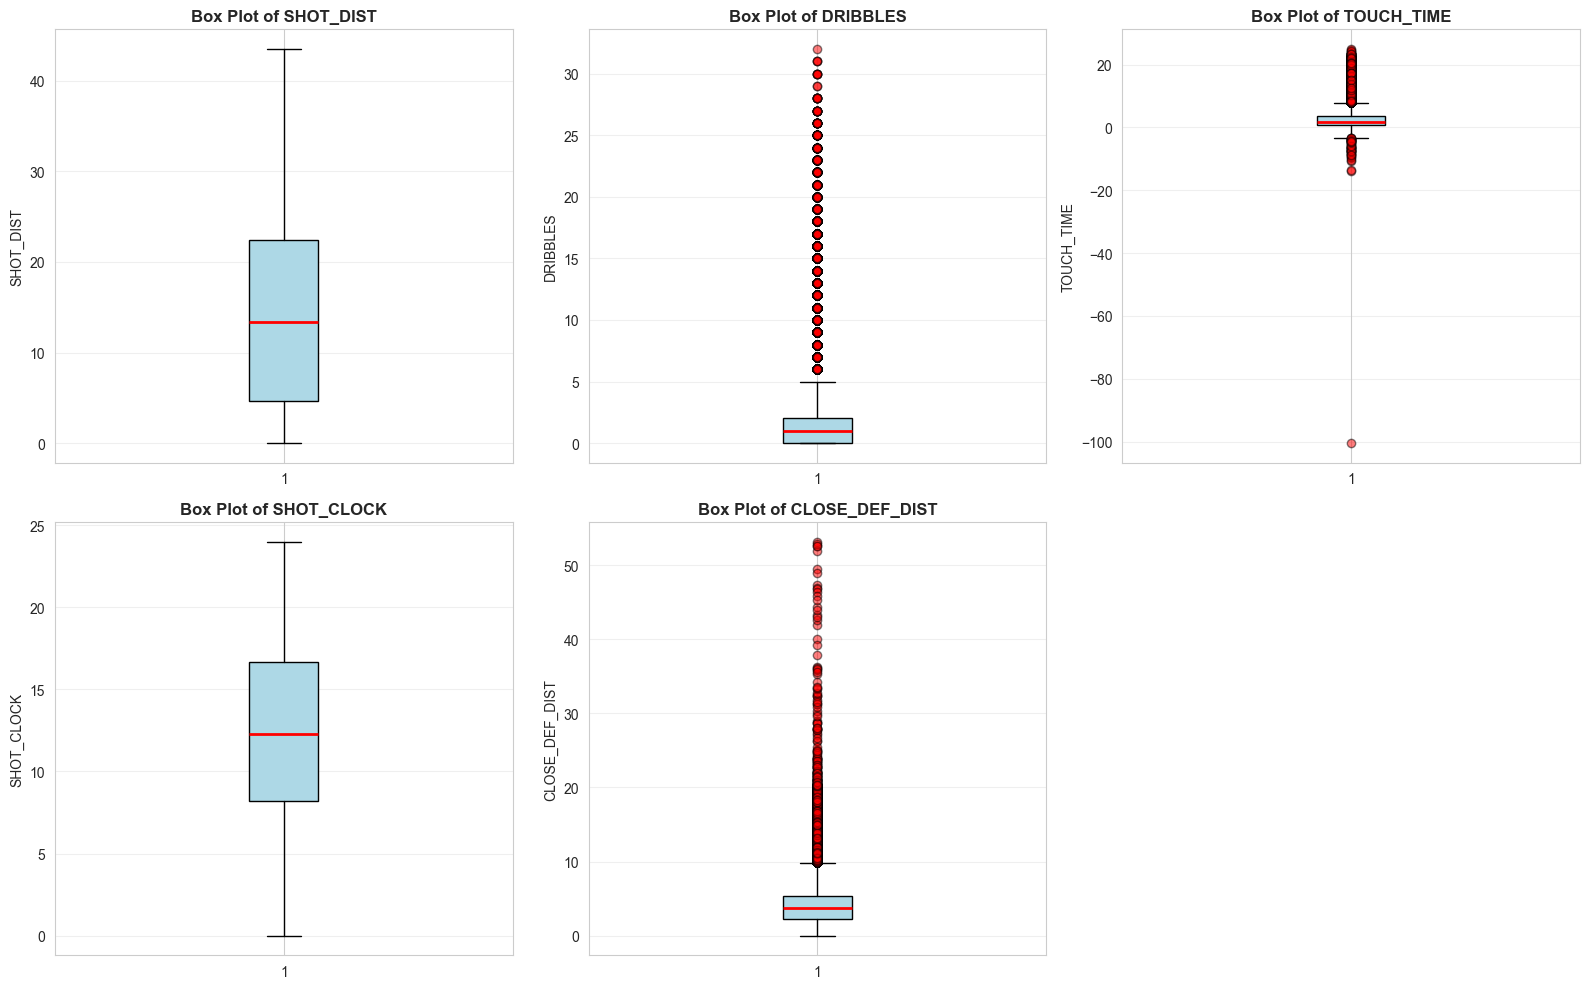

OUTLIER ANALYSIS

SHOT_DIST:
  Q1: 4.70, Q3: 22.40, IQR: 17.70
  Lower Bound: -21.85, Upper Bound: 48.95
  Number of Outliers: 0 (0.00%)
  Outlier Range: [nan, nan]

DRIBBLES:
  Q1: 0.00, Q3: 2.00, IQR: 2.00
  Lower Bound: -3.00, Upper Bound: 5.00
  Number of Outliers: 14032 (11.45%)
  Outlier Range: [6.00, 32.00]

TOUCH_TIME:
  Q1: 0.90, Q3: 3.70, IQR: 2.80
  Lower Bound: -3.30, Upper Bound: 7.90
  Number of Outliers: 7633 (6.23%)
  Outlier Range: [-100.50, 24.90]

SHOT_CLOCK:
  Q1: 8.20, Q3: 16.68, IQR: 8.48
  Lower Bound: -4.51, Upper Bound: 29.39
  Number of Outliers: 0 (0.00%)
  Outlier Range: [nan, nan]

CLOSE_DEF_DIST:
  Q1: 2.30, Q3: 5.30, IQR: 3.00
  Lower Bound: -2.20, Upper Bound: 9.80
  Number of Outliers: 4349 (3.55%)
  Outlier Range: [9.90, 53.20]


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for better-looking plots
sns.set_style("whitegrid")

# Features to analyze
features = ['SHOT_DIST', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_CLOCK', 'CLOSE_DEF_DIST']

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

# Create a box plot for each feature
for idx, feature in enumerate(features):
    axes[idx].boxplot(log_shots[feature], vert=True, patch_artist=True,
                      boxprops=dict(facecolor='lightblue', color='black'),
                      medianprops=dict(color='red', linewidth=2),
                      whiskerprops=dict(color='black'),
                      capprops=dict(color='black'),
                      flierprops=dict(marker='o', markerfacecolor='red', markersize=6, alpha=0.5))
    axes[idx].set_title(f'Box Plot of {feature}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel(feature, fontsize=10)
    axes[idx].grid(True, alpha=0.3, axis='y')

# Hide the extra subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()

# Print outlier information
print("="*70)
print("OUTLIER ANALYSIS")
print("="*70)
for feature in features:
    Q1 = log_shots[feature].quantile(0.25)
    Q3 = log_shots[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = log_shots[(log_shots[feature] < lower_bound) | (log_shots[feature] > upper_bound)]
    
    print(f"\n{feature}:")
    print(f"  Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
    print(f"  Lower Bound: {lower_bound:.2f}, Upper Bound: {upper_bound:.2f}")
    print(f"  Number of Outliers: {len(outliers)} ({len(outliers)/len(log_shots)*100:.2f}%)")
    print(f"  Outlier Range: [{outliers[feature].min():.2f}, {outliers[feature].max():.2f}]")

In [8]:
# ============================================================================
# DROP NEGATIVE VALUES FROM TOUCH_TIME
# ============================================================================

print("="*70)
print("CLEANING TOUCH_TIME - REMOVING NEGATIVE VALUES")
print("="*70)

print(f"\nBefore cleaning:")
print(f"  Total rows: {len(log_shots)}")
print(f"  Negative TOUCH_TIME values: {(log_shots['TOUCH_TIME'] < 0).sum()}")
print(f"  Min TOUCH_TIME: {log_shots['TOUCH_TIME'].min()}")
print(f"  Max TOUCH_TIME: {log_shots['TOUCH_TIME'].max()}")

# Drop rows with negative TOUCH_TIME values
log_shots = log_shots[log_shots['TOUCH_TIME'] >= 0]

print(f"\nAfter cleaning:")
print(f"  Total rows: {len(log_shots)}")
print(f"  Negative TOUCH_TIME values: {(log_shots['TOUCH_TIME'] < 0).sum()}")
print(f"  Min TOUCH_TIME: {log_shots['TOUCH_TIME'].min()}")
print(f"  Max TOUCH_TIME: {log_shots['TOUCH_TIME'].max()}")

print("\n✓ Negative TOUCH_TIME values removed successfully!")

CLEANING TOUCH_TIME - REMOVING NEGATIVE VALUES

Before cleaning:
  Total rows: 122502
  Negative TOUCH_TIME values: 299
  Min TOUCH_TIME: -100.5
  Max TOUCH_TIME: 24.9

After cleaning:
  Total rows: 122203
  Negative TOUCH_TIME values: 0
  Min TOUCH_TIME: 0.0
  Max TOUCH_TIME: 24.9

✓ Negative TOUCH_TIME values removed successfully!



NORMALITY TESTS FOR FEATURES

SHOT_DIST

📊 SHAPIRO-WILK TEST:
   Test Statistic: 0.898977
   P-value: 2.212381e-49
   ✗ NON-NORMAL distribution (p < 0.05)

📊 KOLMOGOROV-SMIRNOV TEST:
   Test Statistic: 0.128948
   P-value: 0.000000e+00
   ✗ NON-NORMAL distribution (p < 0.05)

📊 ANDERSON-DARLING TEST:
   Test Statistic: 4626.078220
   Critical Values: [0.576 0.656 0.787 0.918 1.092]
   Significance Levels: [15.  10.   5.   2.5  1. ]%
   ✗ NON-NORMAL distribution (at 5% level)

📊 DESCRIPTIVE STATISTICS:
   Mean: 13.4491
   Median: 13.4000
   Std Dev: 8.7761
   Skewness: 0.0522
      → Fairly Symmetric ✓
   Kurtosis: -1.5506
      → Normal-like tails ✓

DRIBBLES

📊 SHAPIRO-WILK TEST:
   Test Statistic: 0.641758
   P-value: 4.171705e-73
   ✗ NON-NORMAL distribution (p < 0.05)

📊 KOLMOGOROV-SMIRNOV TEST:
   Test Statistic: 0.279577
   P-value: 0.000000e+00
   ✗ NON-NORMAL distribution (p < 0.05)

📊 ANDERSON-DARLING TEST:
   Test Statistic: 14813.822433
   Critical Values: [0.576 0.656 0.78

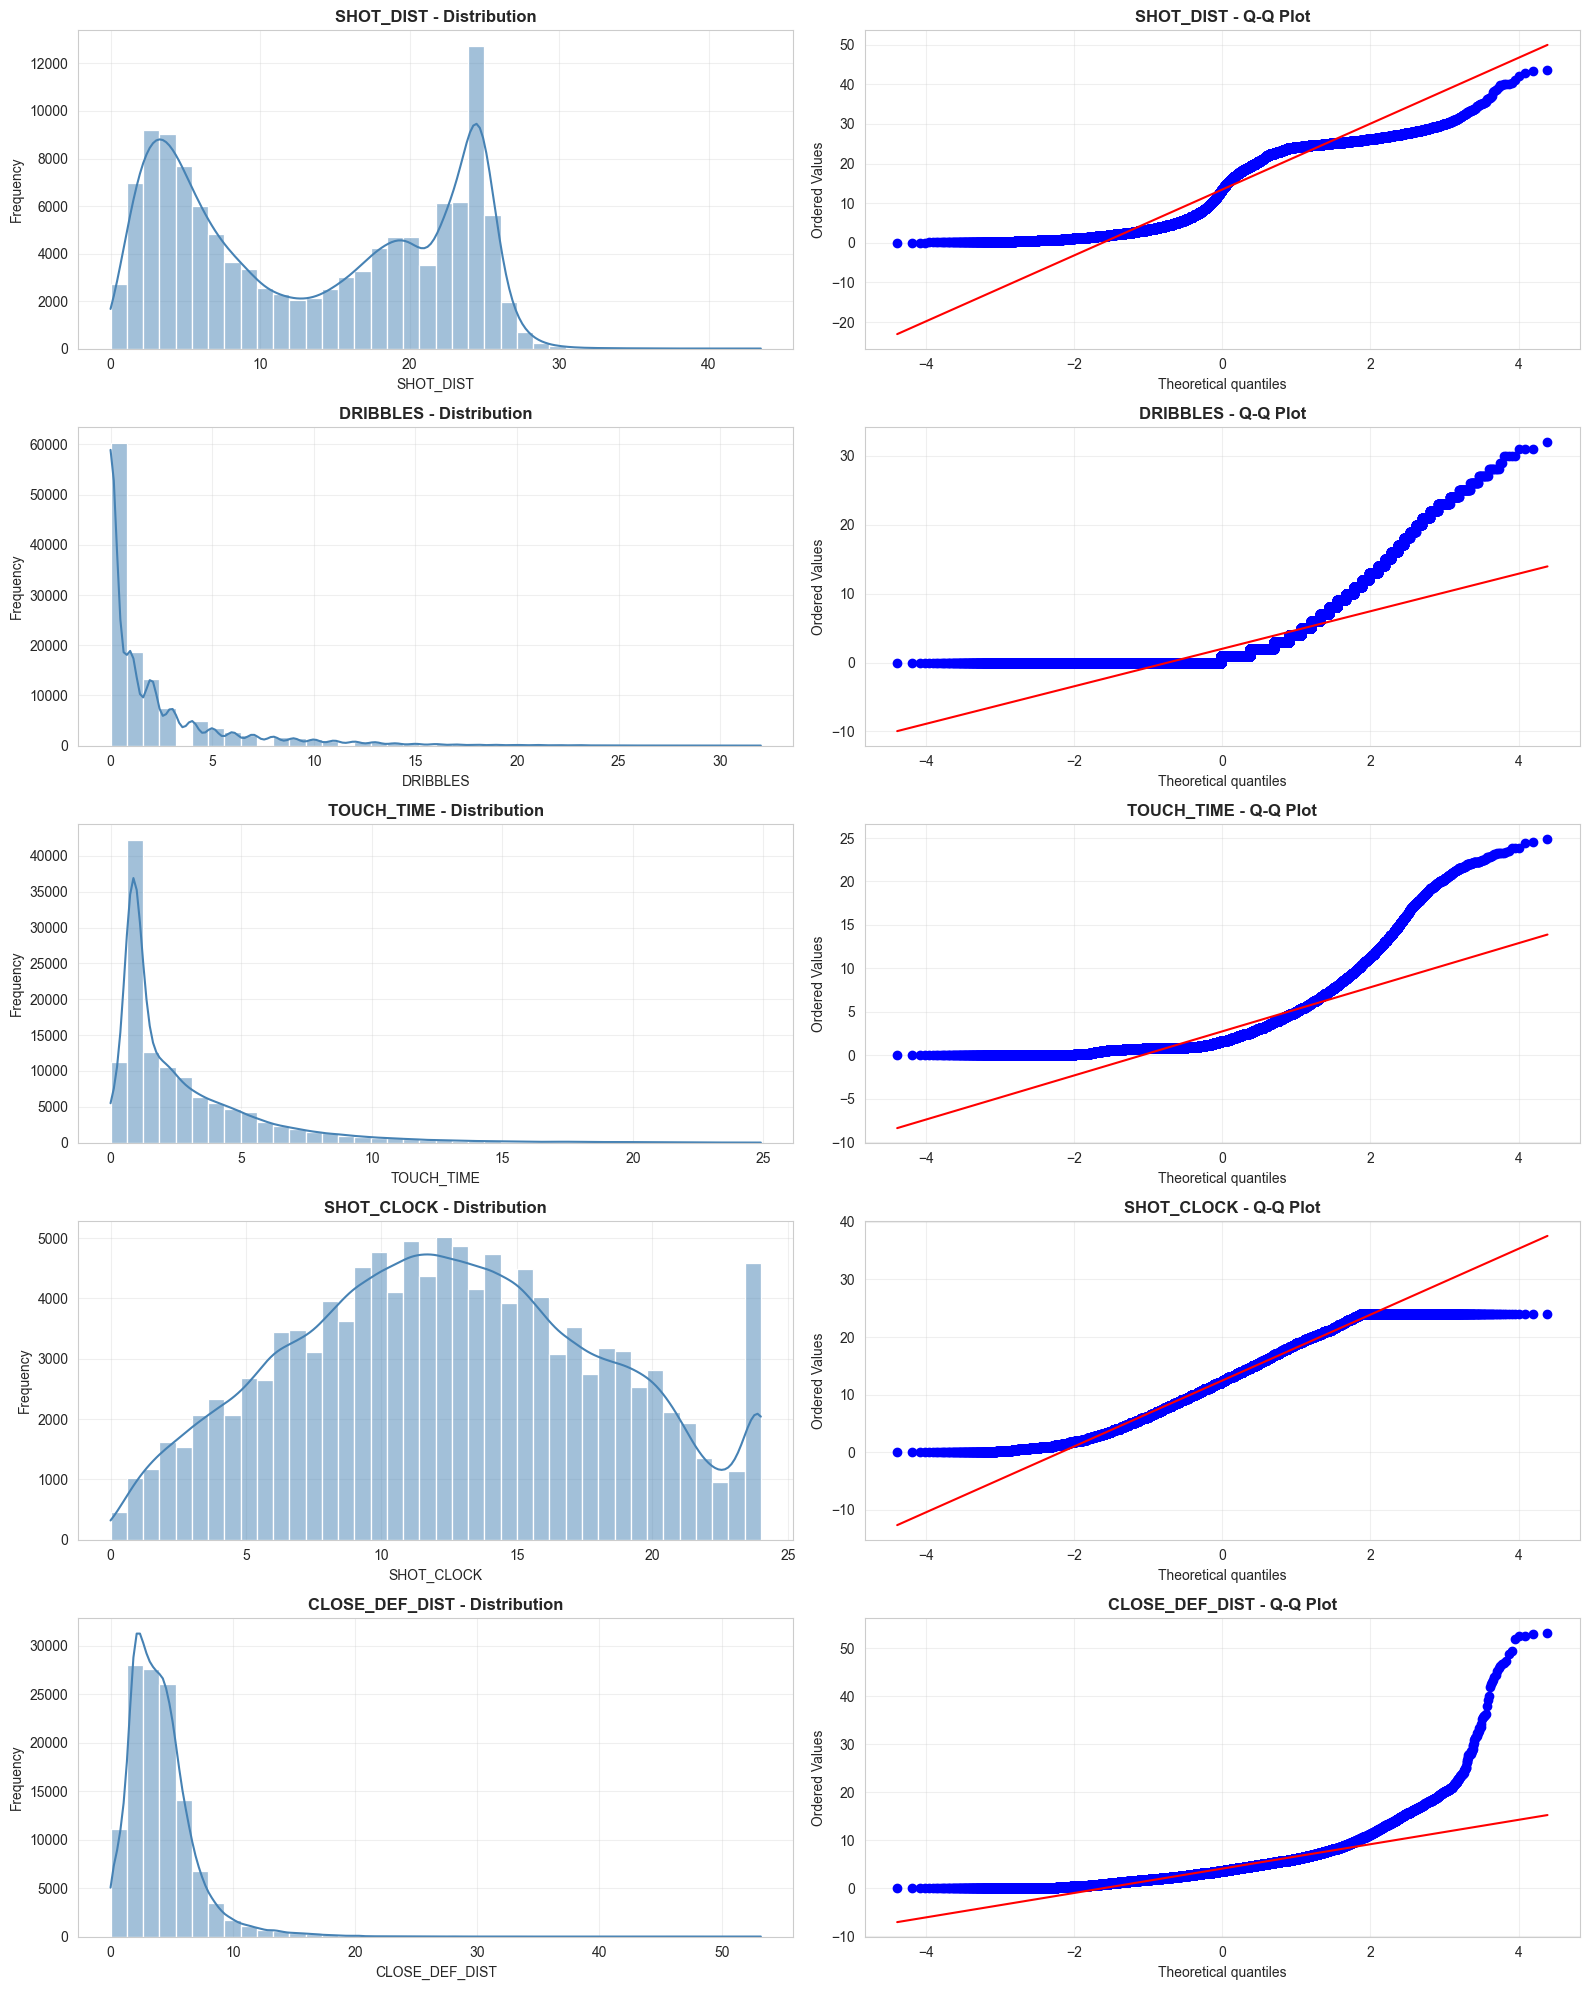


NORMALITY SUMMARY

Feature              Shapiro-Wilk p-value      Normal?        
------------------------------------------------------------
SHOT_DIST            2.212381e-49              ✗ NO           
DRIBBLES             4.171705e-73              ✗ NO           
TOUCH_TIME           7.032260e-66              ✗ NO           
SHOT_CLOCK           1.550016e-21              ✗ NO           
CLOSE_DEF_DIST       1.194830e-59              ✗ NO           



In [9]:

# ============================================================================
# CHECK NORMALITY OF FEATURES
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("\n" + "="*70)
print("NORMALITY TESTS FOR FEATURES")
print("="*70)

# Features to test
features = ['SHOT_DIST', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_CLOCK', 'CLOSE_DEF_DIST']

# Create figure for Q-Q plots and histograms
fig, axes = plt.subplots(len(features), 2, figsize=(16, 4*len(features)))

normality_results = {}

for idx, feature in enumerate(features):
    print(f"\n{'='*70}")
    print(f"{feature}")
    print(f"{'='*70}")
    
    # Get data
    data = log_shots[feature].dropna()
    
    # 1. Shapiro-Wilk Test
    if len(data) > 5000:
        sample_data = data.sample(n=5000, random_state=42)
    else:
        sample_data = data
    
    stat, p_value = stats.shapiro(sample_data)
    normality_results[feature] = {'stat': stat, 'p_value': p_value}
    
    print(f"\n📊 SHAPIRO-WILK TEST:")
    print(f"   Test Statistic: {stat:.6f}")
    print(f"   P-value: {p_value:.6e}")
    if p_value > 0.05:
        print(f"   ✓ NORMAL distribution (p > 0.05)")
    else:
        print(f"   ✗ NON-NORMAL distribution (p < 0.05)")
    
    # 2. Kolmogorov-Smirnov Test (normalized data)
    normalized_data = (data - data.mean()) / data.std()
    ks_stat, ks_p = stats.kstest(normalized_data, 'norm')
    print(f"\n📊 KOLMOGOROV-SMIRNOV TEST:")
    print(f"   Test Statistic: {ks_stat:.6f}")
    print(f"   P-value: {ks_p:.6e}")
    if ks_p > 0.05:
        print(f"   ✓ NORMAL distribution (p > 0.05)")
    else:
        print(f"   ✗ NON-NORMAL distribution (p < 0.05)")
    
    # 3. Anderson-Darling Test
    anderson_result = stats.anderson(data)
    print(f"\n📊 ANDERSON-DARLING TEST:")
    print(f"   Test Statistic: {anderson_result.statistic:.6f}")
    print(f"   Critical Values: {anderson_result.critical_values}")
    print(f"   Significance Levels: {anderson_result.significance_level}%")
    if anderson_result.statistic < anderson_result.critical_values[2]:
        print(f"   ✓ NORMAL distribution (at 5% level)")
    else:
        print(f"   ✗ NON-NORMAL distribution (at 5% level)")
    
    # 4. Descriptive Statistics
    skewness = data.skew()
    kurtosis = data.kurtosis()
    
    print(f"\n📊 DESCRIPTIVE STATISTICS:")
    print(f"   Mean: {data.mean():.4f}")
    print(f"   Median: {data.median():.4f}")
    print(f"   Std Dev: {data.std():.4f}")
    print(f"   Skewness: {skewness:.4f}")
    if abs(skewness) < 0.5:
        print(f"      → Fairly Symmetric ✓")
    elif abs(skewness) < 1:
        print(f"      → Moderately Skewed ⚠")
    else:
        print(f"      → Highly Skewed ✗")
    
    print(f"   Kurtosis: {kurtosis:.4f}")
    if abs(kurtosis) < 3:
        print(f"      → Normal-like tails ✓")
    else:
        print(f"      → Heavy/Light tails ⚠")
    
    # Plot 1: Histogram with KDE
    sns.histplot(data=log_shots, x=feature, bins=40, kde=True, ax=axes[idx, 0], color='steelblue')
    axes[idx, 0].set_title(f'{feature} - Distribution', fontsize=12, fontweight='bold')
    axes[idx, 0].set_ylabel('Frequency')
    axes[idx, 0].grid(True, alpha=0.3)
    
    # Plot 2: Q-Q Plot
    stats.probplot(data, dist="norm", plot=axes[idx, 1])
    axes[idx, 1].set_title(f'{feature} - Q-Q Plot', fontsize=12, fontweight='bold')
    axes[idx, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# SUMMARY TABLE
# ============================================================================

print("\n" + "="*70)
print("NORMALITY SUMMARY")
print("="*70)
print(f"\n{'Feature':<20} {'Shapiro-Wilk p-value':<25} {'Normal?':<15}")
print("-" * 60)
for feature, results in normality_results.items():
    p_val = results['p_value']
    is_normal = "✓ YES" if p_val > 0.05 else "✗ NO"
    print(f"{feature:<20} {p_val:<25.6e} {is_normal:<15}")

print("\n" + "="*70)


APPLYING BEST NORMALIZATION TRANSFORMATIONS

TESTING TRANSFORMATION METHODS

FEATURE: SHOT_DIST

  Yeo-Johnson Transform:
    P-value: 4.408089e-43

  Box-Cox Transform: SKIPPED (requires positive data)

  Quantile Transform:
    P-value: 4.118666e-15

  Robust Scaler:
    P-value: 5.090235e-44

  Standard Scaler:
    P-value: 5.090235e-44

  ✓ BEST METHOD: Quantile
    P-value: 4.118666e-15
    Original p-value: 2.212381e-49
    ✓ IMPROVEMENT achieved (1861643683054926823495487243855855616.00%)

FEATURE: DRIBBLES

  Yeo-Johnson Transform:
    P-value: 2.166223e-58

  Box-Cox Transform: SKIPPED (requires positive data)

  Quantile Transform:
    P-value: 1.931172e-67

  Robust Scaler:
    P-value: 8.559827e-71

  Standard Scaler:
    P-value: 8.559827e-71

  ✓ BEST METHOD: Yeo-Johnson
    P-value: 2.166223e-58
    Original p-value: 4.171705e-73
    ✓ IMPROVEMENT achieved (51926562439971016.00%)

FEATURE: TOUCH_TIME

  Yeo-Johnson Transform:
    P-value: 9.158357e-31

  Box-Cox Transfo

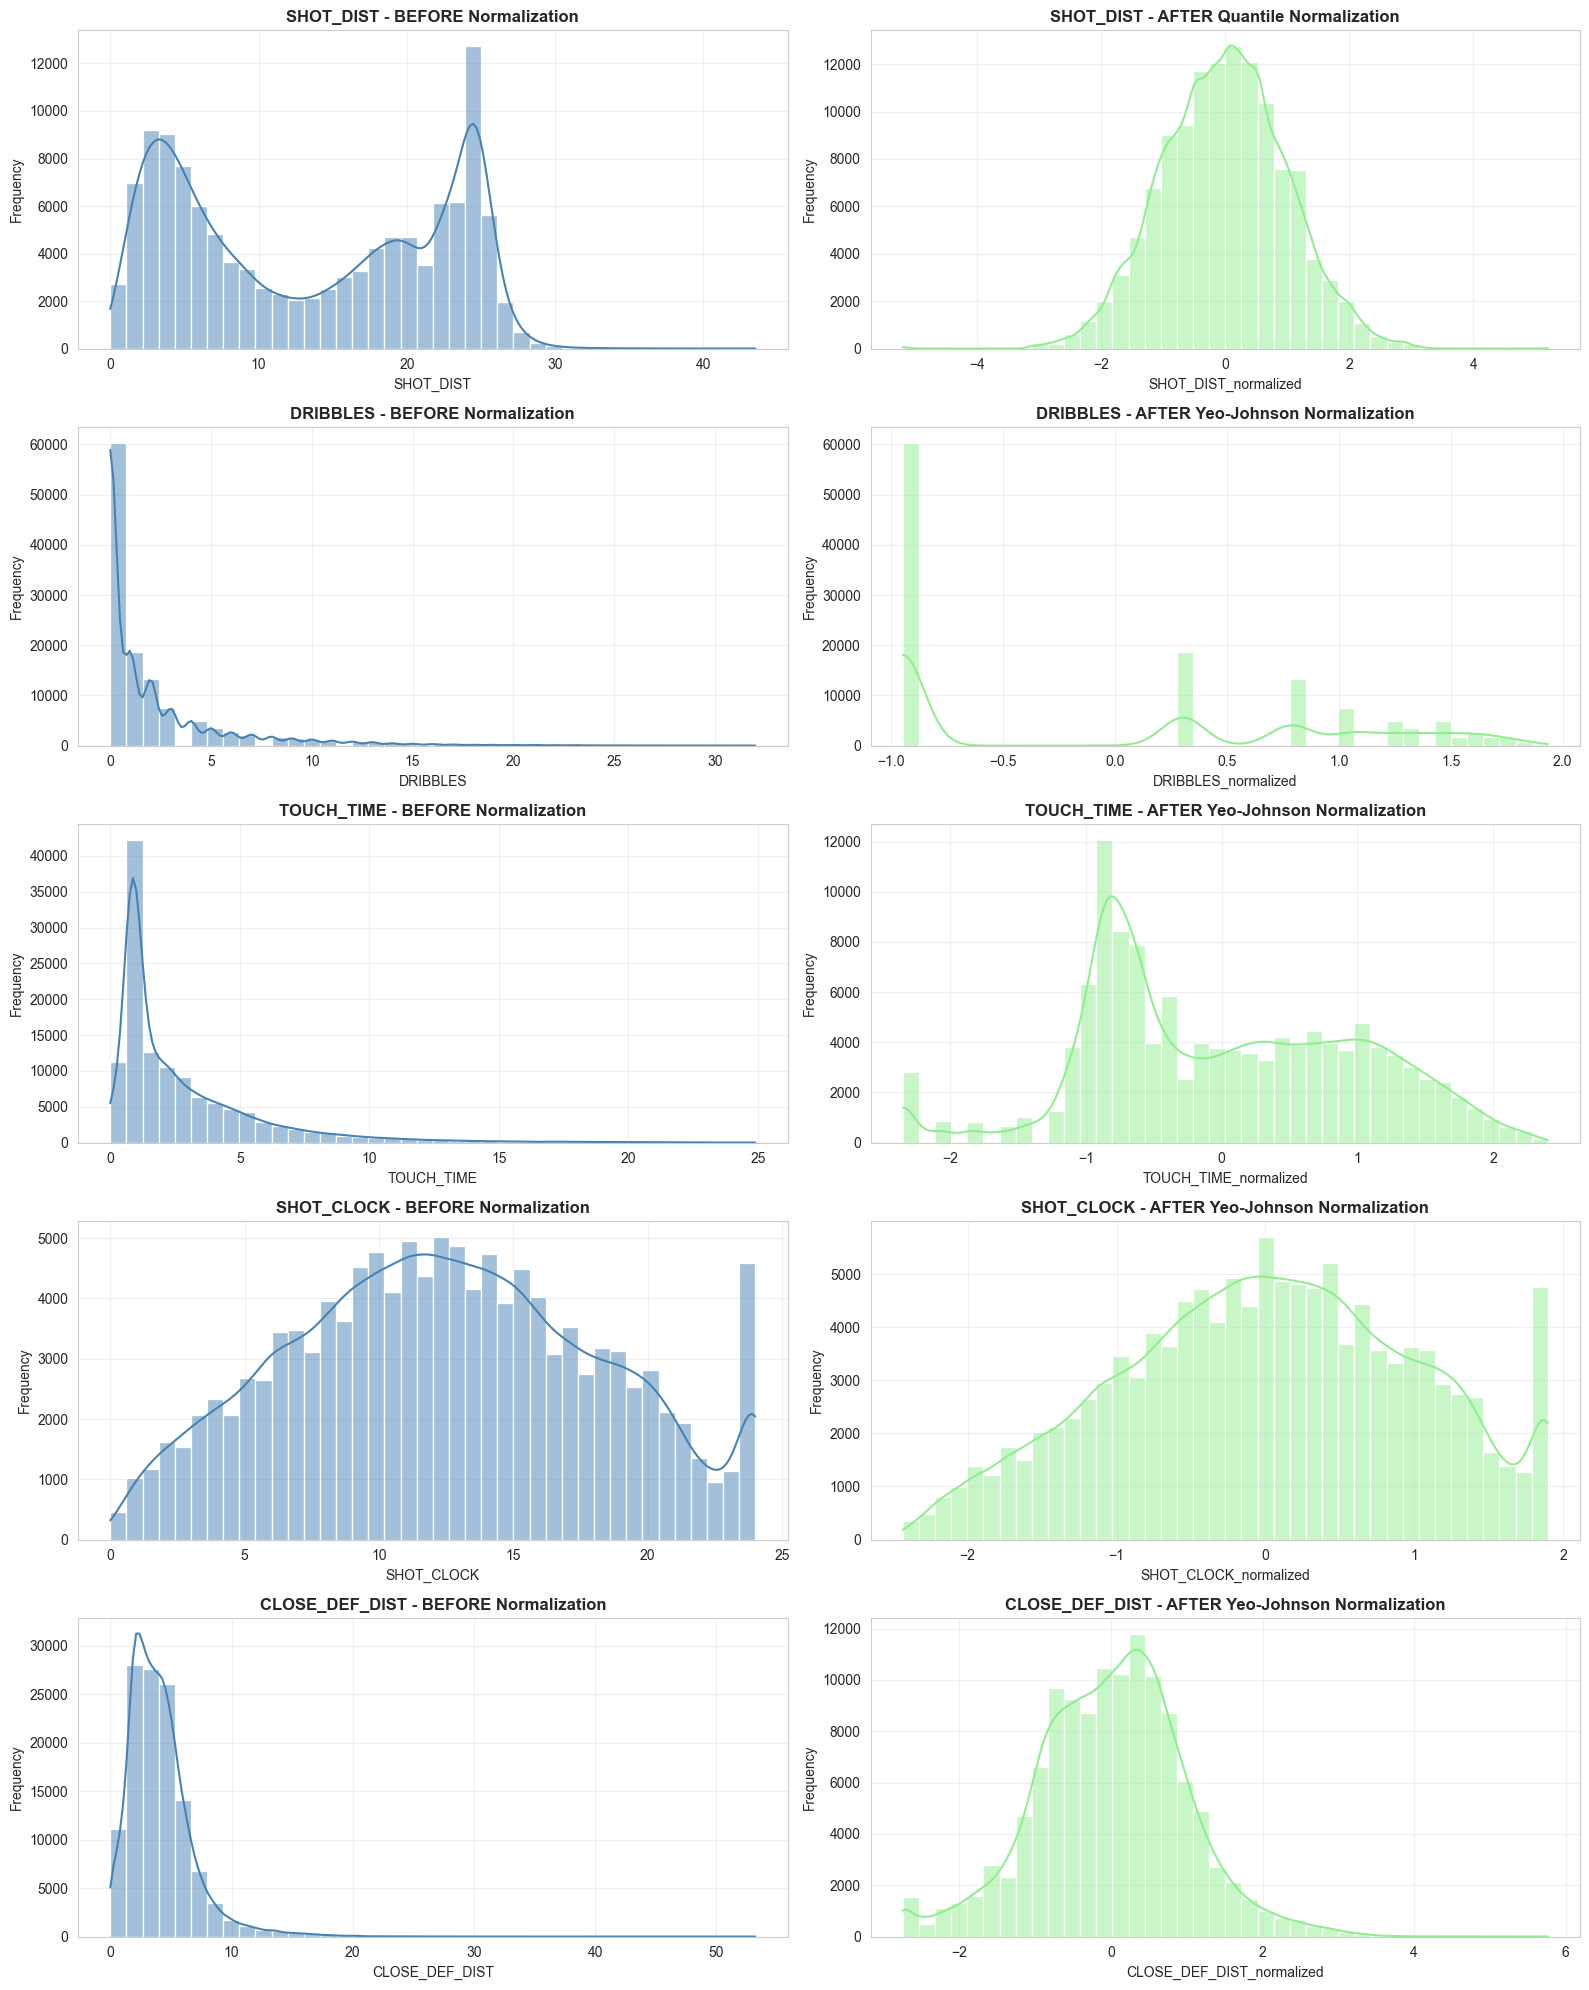


TRANSFORMATION SUMMARY

Feature              Transformation       Before p-value       After p-value        Status         
-----------------------------------------------------------------------------------------------
SHOT_DIST            Quantile             2.212381e-49         4.118666e-15         ✓ BETTER       
DRIBBLES             Yeo-Johnson          4.171705e-73         2.166223e-58         ✓ BETTER       
TOUCH_TIME           Yeo-Johnson          7.032260e-66         9.158357e-31         ✓ BETTER       
SHOT_CLOCK           Yeo-Johnson          1.550016e-21         5.596794e-17         ✓ BETTER       
CLOSE_DEF_DIST       Yeo-Johnson          1.194830e-59         8.913415e-16         ✓ BETTER       

✓ NORMALIZATION COMPLETE!

New normalized columns created:
  SHOT_DIST_normalized
  DRIBBLES_normalized
  TOUCH_TIME_normalized
  SHOT_CLOCK_normalized
  CLOSE_DEF_DIST_normalized

Dataframe shape: (122203, 26)
Total features available: 26


In [10]:
# ============================================================================
# APPLY BEST NORMALIZATION TRANSFORMATIONS
# ============================================================================

from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler, RobustScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("\n" + "="*70)
print("APPLYING BEST NORMALIZATION TRANSFORMATIONS")
print("="*70)

# Features to transform
features = ['SHOT_DIST', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_CLOCK', 'CLOSE_DEF_DIST']

# Create a copy of the dataframe for transformed data
log_shots_normalized = log_shots.copy()

# Store transformation objects and results
transformation_methods = {}
normalizers = {}
transformation_details = {}

# ============================================================================
# 1. TEST EACH TRANSFORMATION METHOD
# ============================================================================

print("\n" + "="*70)
print("TESTING TRANSFORMATION METHODS")
print("="*70)

for feature in features:
    print(f"\n{'='*70}")
    print(f"FEATURE: {feature}")
    print(f"{'='*70}")
    
    original_data = log_shots[feature].values.reshape(-1, 1)
    
    # Dictionary to store all transformations and their p-values
    transformation_results = {}
    
    # 1. Yeo-Johnson Power Transform
    try:
        pt_yj = PowerTransformer(method='yeo-johnson')
        transformed_yj = pt_yj.fit_transform(original_data)
        sample_yj = transformed_yj[:5000].flatten() if len(transformed_yj) > 5000 else transformed_yj.flatten()
        stat_yj, p_yj = stats.shapiro(sample_yj)
        transformation_results['Yeo-Johnson'] = {
            'p_value': p_yj,
            'transformer': pt_yj,
            'data': transformed_yj
        }
        print(f"\n  Yeo-Johnson Transform:")
        print(f"    P-value: {p_yj:.6e}")
    except Exception as e:
        print(f"\n  Yeo-Johnson Transform: FAILED - {str(e)}")
    
    # 2. Box-Cox Power Transform (only for positive data)
    try:
        if (original_data > 0).all():
            pt_bc = PowerTransformer(method='box-cox')
            transformed_bc = pt_bc.fit_transform(original_data)
            sample_bc = transformed_bc[:5000].flatten() if len(transformed_bc) > 5000 else transformed_bc.flatten()
            stat_bc, p_bc = stats.shapiro(sample_bc)
            transformation_results['Box-Cox'] = {
                'p_value': p_bc,
                'transformer': pt_bc,
                'data': transformed_bc
            }
            print(f"\n  Box-Cox Transform:")
            print(f"    P-value: {p_bc:.6e}")
        else:
            print(f"\n  Box-Cox Transform: SKIPPED (requires positive data)")
    except Exception as e:
        print(f"\n  Box-Cox Transform: FAILED - {str(e)}")
    
    # 3. Quantile Transformer (Gaussian output)
    try:
        qt = QuantileTransformer(output_distribution='normal', random_state=42)
        transformed_qt = qt.fit_transform(original_data)
        sample_qt = transformed_qt[:5000].flatten() if len(transformed_qt) > 5000 else transformed_qt.flatten()
        stat_qt, p_qt = stats.shapiro(sample_qt)
        transformation_results['Quantile'] = {
            'p_value': p_qt,
            'transformer': qt,
            'data': transformed_qt
        }
        print(f"\n  Quantile Transform:")
        print(f"    P-value: {p_qt:.6e}")
    except Exception as e:
        print(f"\n  Quantile Transform: FAILED - {str(e)}")
    
    # 4. Robust Scaler
    try:
        rs = RobustScaler()
        transformed_rs = rs.fit_transform(original_data)
        sample_rs = transformed_rs[:5000].flatten() if len(transformed_rs) > 5000 else transformed_rs.flatten()
        stat_rs, p_rs = stats.shapiro(sample_rs)
        transformation_results['RobustScaler'] = {
            'p_value': p_rs,
            'transformer': rs,
            'data': transformed_rs
        }
        print(f"\n  Robust Scaler:")
        print(f"    P-value: {p_rs:.6e}")
    except Exception as e:
        print(f"\n  Robust Scaler: FAILED - {str(e)}")
    
    # 5. Standard Scaler
    try:
        ss = StandardScaler()
        transformed_ss = ss.fit_transform(original_data)
        sample_ss = transformed_ss[:5000].flatten() if len(transformed_ss) > 5000 else transformed_ss.flatten()
        stat_ss, p_ss = stats.shapiro(sample_ss)
        transformation_results['StandardScaler'] = {
            'p_value': p_ss,
            'transformer': ss,
            'data': transformed_ss
        }
        print(f"\n  Standard Scaler:")
        print(f"    P-value: {p_ss:.6e}")
    except Exception as e:
        print(f"\n  Standard Scaler: FAILED - {str(e)}")
    
    # Select best transformation
    best_method = max(transformation_results.items(), key=lambda x: x[1]['p_value'])
    
    transformation_methods[feature] = best_method[0]
    normalizers[feature] = best_method[1]['transformer']
    transformation_details[feature] = {
        'p_value': best_method[1]['p_value'],
        'method': best_method[0],
        'all_methods': transformation_results
    }
    
    # Apply best transformation
    log_shots_normalized[f'{feature}_normalized'] = best_method[1]['data'].flatten()
    
    print(f"\n  ✓ BEST METHOD: {best_method[0]}")
    print(f"    P-value: {best_method[1]['p_value']:.6e}")
    print(f"    Original p-value: {normality_results[feature]['p_value']:.6e}")
    
    if best_method[1]['p_value'] > normality_results[feature]['p_value']:
        improvement = abs((best_method[1]['p_value'] - normality_results[feature]['p_value']) / normality_results[feature]['p_value'] * 100)
        print(f"    ✓ IMPROVEMENT achieved ({improvement:.2f}%)")
    else:
        print(f"    ⚠ Limited improvement")

# ============================================================================
# 2. VISUALIZE BEFORE & AFTER TRANSFORMATIONS
# ============================================================================

print("\n" + "="*70)
print("VISUALIZING TRANSFORMATIONS")
print("="*70)

fig, axes = plt.subplots(len(features), 2, figsize=(16, 4*len(features)))

for idx, feature in enumerate(features):
    # Original distribution
    sns.histplot(data=log_shots, x=feature, bins=40, kde=True, ax=axes[idx, 0], color='steelblue')
    axes[idx, 0].set_title(f'{feature} - BEFORE Normalization', fontsize=12, fontweight='bold')
    axes[idx, 0].set_ylabel('Frequency')
    axes[idx, 0].grid(True, alpha=0.3)
    
    # Normalized distribution
    normalized_col = f'{feature}_normalized'
    temp_df = pd.DataFrame({normalized_col: log_shots_normalized[normalized_col]})
    sns.histplot(data=temp_df, x=normalized_col, bins=40, kde=True, ax=axes[idx, 1], color='lightgreen')
    axes[idx, 1].set_title(f'{feature} - AFTER {transformation_methods[feature]} Normalization', fontsize=12, fontweight='bold')
    axes[idx, 1].set_ylabel('Frequency')
    axes[idx, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# 3. SUMMARY TABLE
# ============================================================================

print("\n" + "="*70)
print("TRANSFORMATION SUMMARY")
print("="*70)
print(f"\n{'Feature':<20} {'Transformation':<20} {'Before p-value':<20} {'After p-value':<20} {'Status':<15}")
print("-" * 95)

for feature in features:
    before_p = normality_results[feature]['p_value']
    after_p = transformation_details[feature]['p_value']
    method = transformation_methods[feature]
    status = "✓ BETTER" if after_p > before_p else "⚠ SAME/WORSE"
    
    print(f"{feature:<20} {method:<20} {before_p:<20.6e} {after_p:<20.6e} {status:<15}")

print("\n" + "="*70)
print("✓ NORMALIZATION COMPLETE!")
print("="*70)
print(f"\nNew normalized columns created:")
for feature in features:
    print(f"  {feature}_normalized")

print(f"\nDataframe shape: {log_shots_normalized.shape}")
print(f"Total features available: {len(log_shots_normalized.columns)}")

In [11]:

# ============================================================================
# PREPARE DATA FOR BOX-COX: ELIMINATE NEGATIVE/ZERO VALUES
# ============================================================================

print("\n" + "="*70)
print("PREPARING DATA FOR BOX-COX TRANSFORMATION")
print("="*70)

# Features to analyze
features = ['SHOT_DIST', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_CLOCK', 'CLOSE_DEF_DIST']

# Create a working copy
log_shots_boxcox = log_shots.copy()

print("\nAnalyzing feature values for Box-Cox requirements:")
print("(Box-Cox requires STRICTLY POSITIVE values: > 0)\n")

for feature in features:
    min_val = log_shots[feature].min()
    max_val = log_shots[feature].max()
    zero_count = (log_shots[feature] == 0).sum()
    negative_count = (log_shots[feature] < 0).sum()
    
    print(f"\n{feature}:")
    print(f"  Min value: {min_val:.4f}")
    print(f"  Max value: {max_val:.4f}")
    print(f"  Zero values: {zero_count}")
    print(f"  Negative values: {negative_count}")
    
    if min_val <= 0:
        print(f"  ⚠ Contains non-positive values - needs adjustment")
    else:
        print(f"  ✓ All positive - Box-Cox ready")

# ============================================================================
# ELIMINATE NEGATIVE AND ZERO VALUES
# ============================================================================

print("\n" + "="*70)
print("REMOVING NEGATIVE/ZERO VALUES")
print("="*70)

print(f"\nBefore removal: {len(log_shots_boxcox)} rows")

# Remove rows with negative or zero values in any feature
mask = (log_shots_boxcox['SHOT_DIST'] > 0) & \
       (log_shots_boxcox['DRIBBLES'] > 0) & \
       (log_shots_boxcox['TOUCH_TIME'] > 0) & \
       (log_shots_boxcox['SHOT_CLOCK'] > 0) & \
       (log_shots_boxcox['CLOSE_DEF_DIST'] > 0)

rows_removed = len(log_shots_boxcox) - mask.sum()
log_shots_boxcox = log_shots_boxcox[mask]

print(f"After removal: {len(log_shots_boxcox)} rows")
print(f"Rows removed: {rows_removed} ({rows_removed/len(log_shots)*100:.2f}%)")

print("\n✓ Data is now ready for Box-Cox transformation!")

print("\nVerifying all values are positive:")
for feature in features:
    min_val = log_shots_boxcox[feature].min()
    max_val = log_shots_boxcox[feature].max()
    print(f"  {feature}: [{min_val:.4f}, {max_val:.4f}] ✓")


PREPARING DATA FOR BOX-COX TRANSFORMATION

Analyzing feature values for Box-Cox requirements:
(Box-Cox requires STRICTLY POSITIVE values: > 0)


SHOT_DIST:
  Min value: 0.0000
  Max value: 43.5000
  Zero values: 4
  Negative values: 0
  ⚠ Contains non-positive values - needs adjustment

DRIBBLES:
  Min value: 0.0000
  Max value: 32.0000
  Zero values: 60380
  Negative values: 0
  ⚠ Contains non-positive values - needs adjustment

TOUCH_TIME:
  Min value: 0.0000
  Max value: 24.9000
  Zero values: 2817
  Negative values: 0
  ⚠ Contains non-positive values - needs adjustment

SHOT_CLOCK:
  Min value: 0.0000
  Max value: 24.0000
  Zero values: 76
  Negative values: 0
  ⚠ Contains non-positive values - needs adjustment

CLOSE_DEF_DIST:
  Min value: 0.0000
  Max value: 53.2000
  Zero values: 996
  Negative values: 0
  ⚠ Contains non-positive values - needs adjustment

REMOVING NEGATIVE/ZERO VALUES

Before removal: 122203 rows
After removal: 61211 rows
Rows removed: 60992 (49.91%)

✓ Data i


APPLYING BOX-COX TRANSFORMATION

Applying Box-Cox transformation to each feature:

SHOT_DIST

  ✓ Box-Cox Applied Successfully!
    Lambda parameter (λ): 0.382257
    Shapiro-Wilk p-value: 4.798867e-33
    Original p-value: 2.212381e-49
    ✓ IMPROVED normality (-2169095606977272064.00% increase in p-value)
DRIBBLES

  ✓ Box-Cox Applied Successfully!
    Lambda parameter (λ): -0.293221
    Shapiro-Wilk p-value: 6.607116e-52
    Original p-value: 4.171705e-73
    ✓ IMPROVED normality (-158379250994997731786752.00% increase in p-value)
TOUCH_TIME

  ✓ Box-Cox Applied Successfully!
    Lambda parameter (λ): -0.076996
    Shapiro-Wilk p-value: 2.021356e-11
    Original p-value: 7.032260e-66
    ✓ IMPROVED normality (-287440396912108575539812442776626281956173734777582518272.00% increase in p-value)
SHOT_CLOCK

  ✓ Box-Cox Applied Successfully!
    Lambda parameter (λ): -0.076996
    Shapiro-Wilk p-value: 2.021356e-11
    Original p-value: 7.032260e-66
    ✓ IMPROVED normality (-2874403969

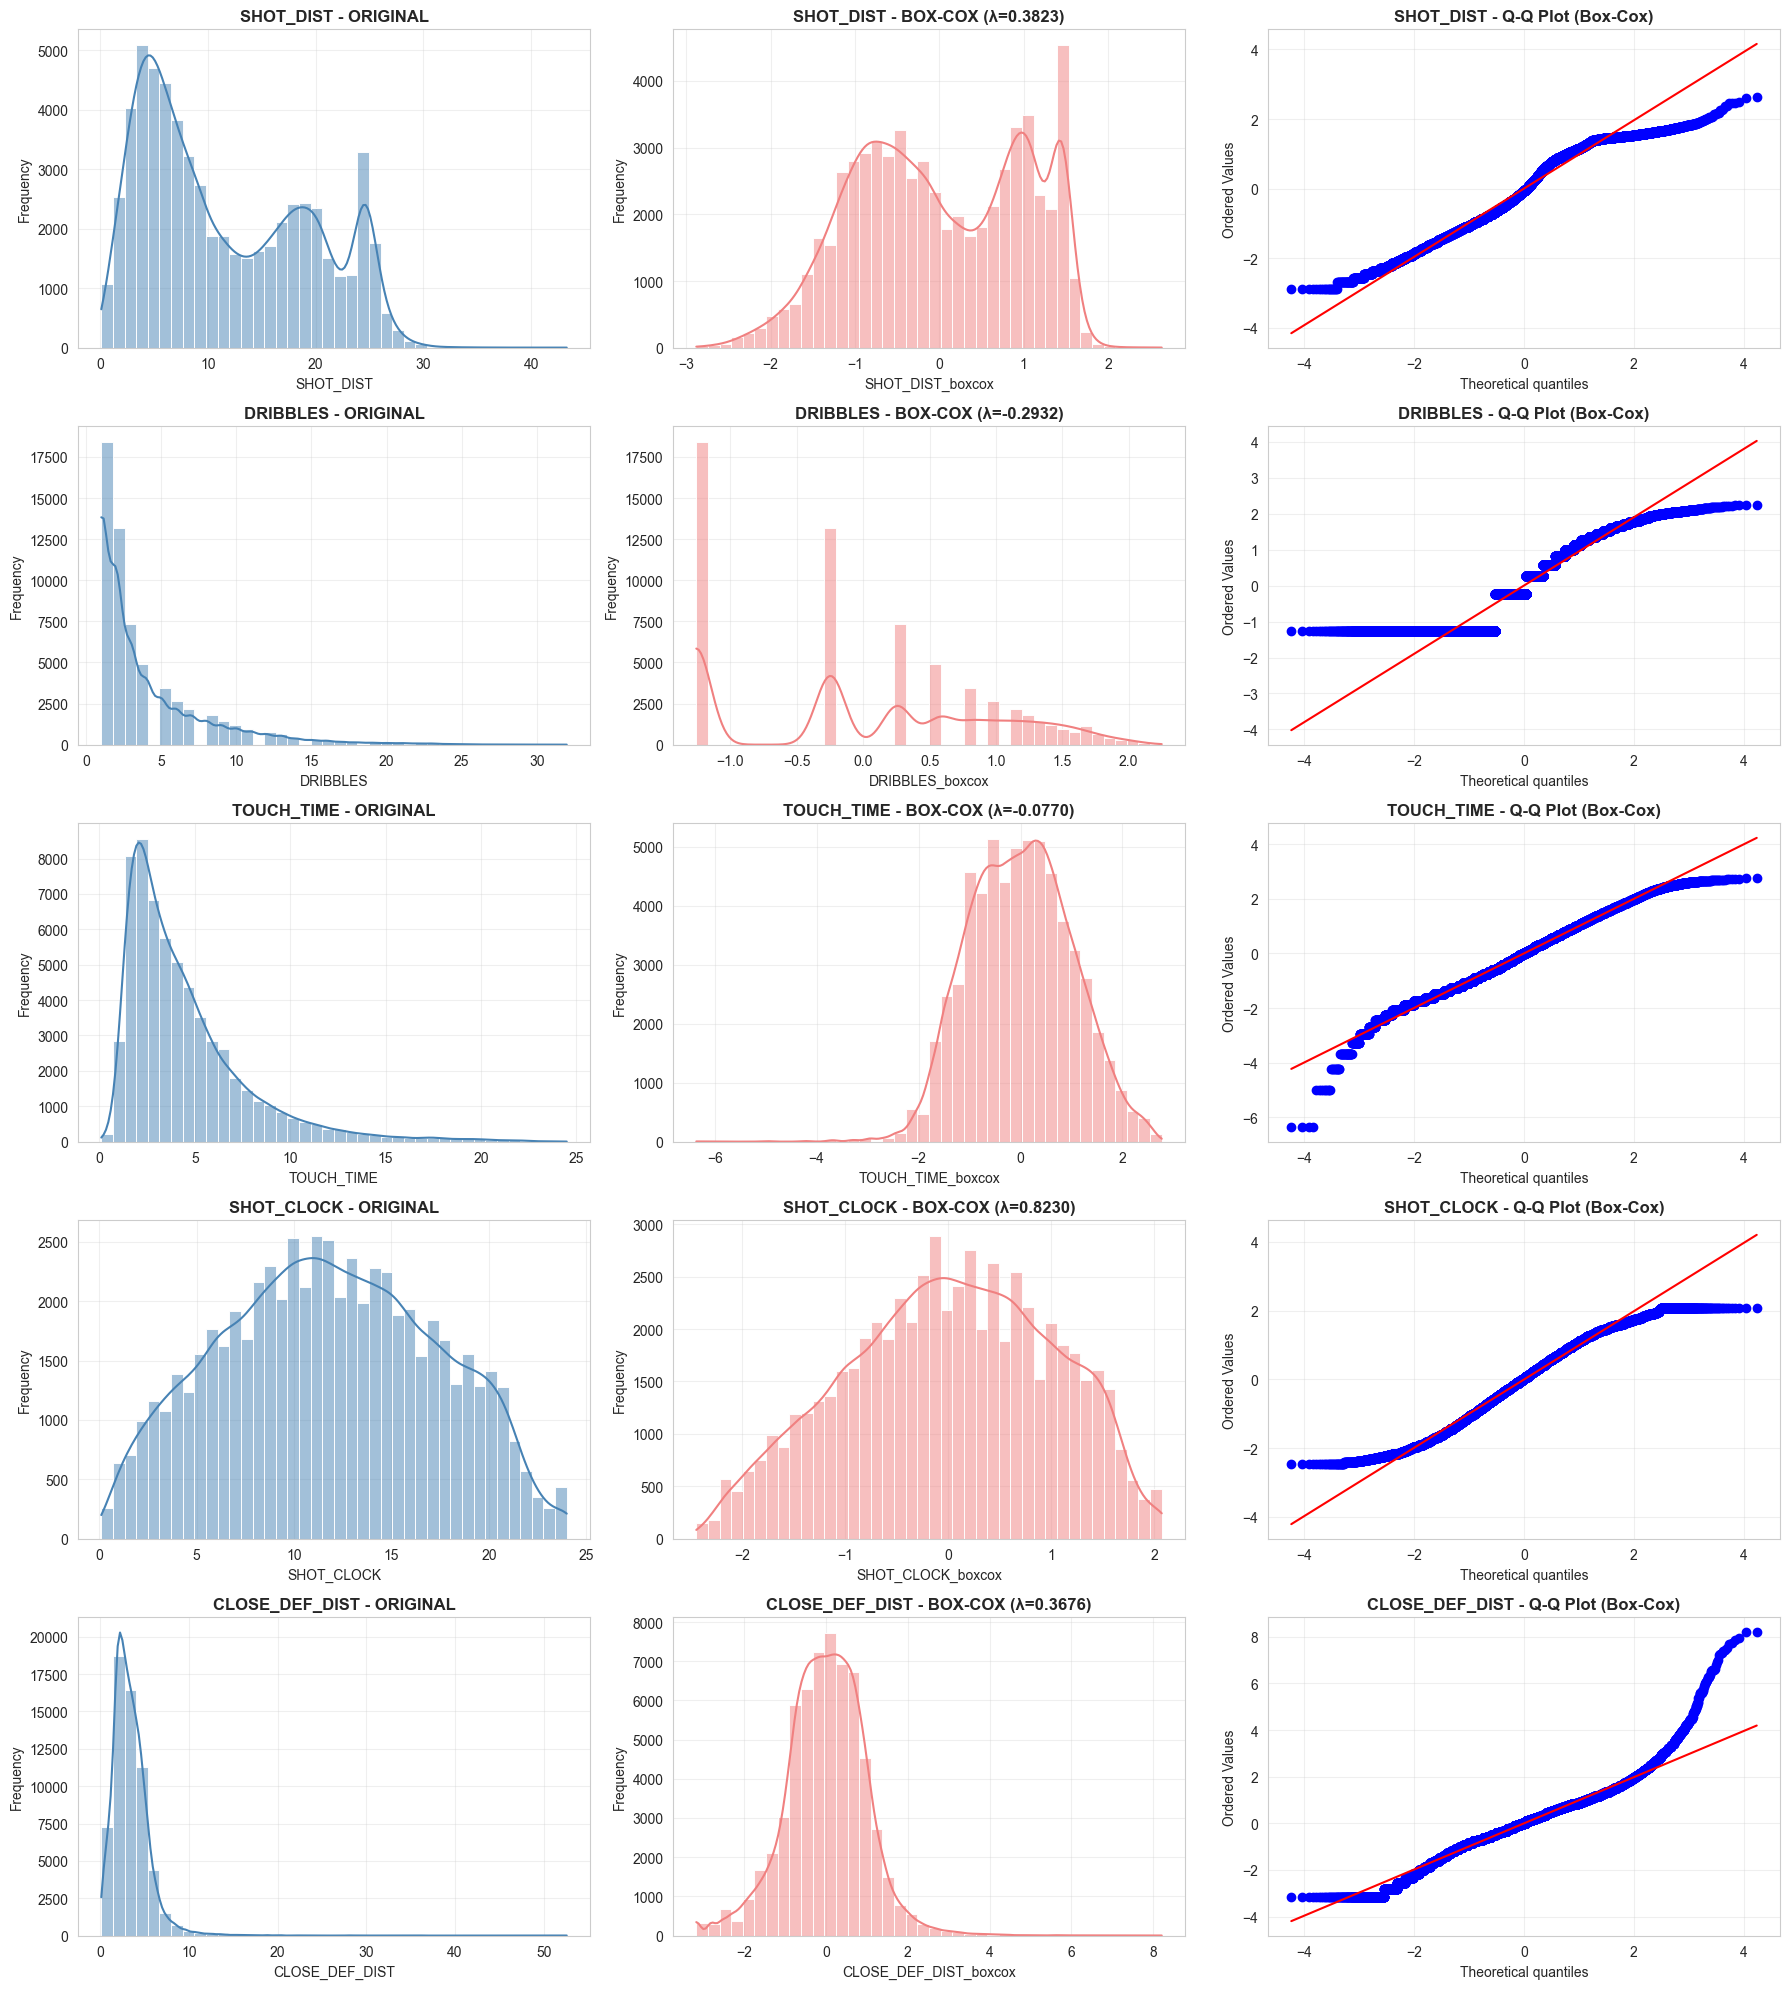


BOX-COX TRANSFORMATION SUMMARY

Feature              Lambda       Original p-val       Box-Cox p-val        Status         
---------------------------------------------------------------------------------------
SHOT_DIST            0.382257     2.212381e-49         4.798867e-33         ✓ BETTER       
DRIBBLES             -0.293221    4.171705e-73         6.607116e-52         ✓ BETTER       
TOUCH_TIME           -0.076996    7.032260e-66         2.021356e-11         ✓ BETTER       
SHOT_CLOCK           0.822999     1.550016e-21         1.090322e-18         ✓ BETTER       
CLOSE_DEF_DIST       0.367570     1.194830e-59         1.174066e-25         ✓ BETTER       

✓ BOX-COX TRANSFORMATION COMPLETE!

New Box-Cox columns created:
  SHOT_DIST_boxcox
  DRIBBLES_boxcox
  TOUCH_TIME_boxcox
  SHOT_CLOCK_boxcox
  CLOSE_DEF_DIST_boxcox

Cleaned dataset shape: (61211, 26)
Note: Dataset size reduced from 122203 to 61211 rows
      (removed rows with zero/negative values)


In [12]:

# ============================================================================
# APPLY BOX-COX TRANSFORMATION WITH POSITIVE DATA
# ============================================================================

from sklearn.preprocessing import PowerTransformer
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*70)
print("APPLYING BOX-COX TRANSFORMATION")
print("="*70)

features = ['SHOT_DIST', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_CLOCK', 'CLOSE_DEF_DIST']

# Create a working copy with positive-only data
log_shots_boxcox_transformed = log_shots_boxcox.copy()

# Store results
boxcox_methods = {}
boxcox_normalizers = {}
boxcox_details = {}

print("\nApplying Box-Cox transformation to each feature:\n")

for feature in features:
    print(f"{'='*70}")
    print(f"{feature}")
    print(f"{'='*70}")
    
    original_data = log_shots_boxcox[feature].values.reshape(-1, 1)
    
    try:
        # Apply Box-Cox transformation
        pt_bc = PowerTransformer(method='box-cox')
        transformed_bc = pt_bc.fit_transform(original_data)
        
        # Get lambda parameter used
        lambda_param = pt_bc.lambdas_[0]
        
        # Test normality
        sample_bc = transformed_bc[:5000].flatten() if len(transformed_bc) > 5000 else transformed_bc.flatten()
        stat_bc, p_bc = stats.shapiro(sample_bc)
        
        # Store results
        boxcox_methods[feature] = 'Box-Cox'
        boxcox_normalizers[feature] = pt_bc
        boxcox_details[feature] = {
            'p_value': p_bc,
            'lambda': lambda_param,
            'data': transformed_bc
        }
        
        log_shots_boxcox_transformed[f'{feature}_boxcox'] = transformed_bc.flatten()
        
        print(f"\n  ✓ Box-Cox Applied Successfully!")
        print(f"    Lambda parameter (λ): {lambda_param:.6f}")
        print(f"    Shapiro-Wilk p-value: {p_bc:.6e}")
        
        # Get original p-value for comparison
        if feature in normality_results:
            original_p = normality_results[feature]['p_value']
            print(f"    Original p-value: {original_p:.6e}")
            
            if p_bc > original_p:
                improvement = ((original_p - p_bc) / original_p * 100)
                print(f"    ✓ IMPROVED normality ({improvement:.2f}% increase in p-value)")
            else:
                print(f"    ⚠ Limited normality improvement")
    
    except Exception as e:
        print(f"\n  ✗ Box-Cox FAILED: {str(e)}")

# ============================================================================
# VISUALIZE BOX-COX TRANSFORMATIONS
# ============================================================================

print("\n" + "="*70)
print("VISUALIZING BOX-COX TRANSFORMATIONS")
print("="*70)

fig, axes = plt.subplots(len(features), 3, figsize=(18, 4*len(features)))

for idx, feature in enumerate(features):
    if feature in boxcox_details:
        # Original data
        sns.histplot(data=log_shots_boxcox, x=feature, bins=40, kde=True, ax=axes[idx, 0], color='steelblue')
        axes[idx, 0].set_title(f'{feature} - ORIGINAL', fontsize=12, fontweight='bold')
        axes[idx, 0].set_ylabel('Frequency')
        axes[idx, 0].grid(True, alpha=0.3)
        
        # Box-Cox transformed
        boxcox_col = f'{feature}_boxcox'
        temp_df = pd.DataFrame({boxcox_col: log_shots_boxcox_transformed[boxcox_col]})
        sns.histplot(data=temp_df, x=boxcox_col, bins=40, kde=True, ax=axes[idx, 1], color='lightcoral')
        lambda_val = boxcox_details[feature]['lambda']
        axes[idx, 1].set_title(f'{feature} - BOX-COX (λ={lambda_val:.4f})', fontsize=12, fontweight='bold')
        axes[idx, 1].set_ylabel('Frequency')
        axes[idx, 1].grid(True, alpha=0.3)
        
        # Q-Q Plot for Box-Cox
        stats.probplot(log_shots_boxcox_transformed[boxcox_col], dist="norm", plot=axes[idx, 2])
        axes[idx, 2].set_title(f'{feature} - Q-Q Plot (Box-Cox)', fontsize=12, fontweight='bold')
        axes[idx, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# COMPARISON TABLE: ORIGINAL vs BOX-COX
# ============================================================================

print("\n" + "="*70)
print("BOX-COX TRANSFORMATION SUMMARY")
print("="*70)
print(f"\n{'Feature':<20} {'Lambda':<12} {'Original p-val':<20} {'Box-Cox p-val':<20} {'Status':<15}")
print("-" * 87)

for feature in features:
    if feature in boxcox_details:
        lambda_val = boxcox_details[feature]['lambda']
        boxcox_p = boxcox_details[feature]['p_value']
        
        if feature in normality_results:
            original_p = normality_results[feature]['p_value']
            status = "✓ BETTER" if boxcox_p > original_p else "⚠ SAME/WORSE"
            print(f"{feature:<20} {lambda_val:<12.6f} {original_p:<20.6e} {boxcox_p:<20.6e} {status:<15}")
        else:
            print(f"{feature:<20} {lambda_val:<12.6f} {'N/A':<20} {boxcox_p:<20.6e} {'NEW':<15}")

print("\n" + "="*70)
print("✓ BOX-COX TRANSFORMATION COMPLETE!")
print("="*70)
print(f"\nNew Box-Cox columns created:")
for feature in features:
    if feature in boxcox_details:
        print(f"  {feature}_boxcox")

print(f"\nCleaned dataset shape: {log_shots_boxcox_transformed.shape}")
print(f"Note: Dataset size reduced from {len(log_shots)} to {len(log_shots_boxcox_transformed)} rows")
print(f"      (removed rows with zero/negative values)")


FINAL DECISION: APPLYING USER-SPECIFIED TRANSFORMATIONS

User-Selected Transformations:
  CLOSE_DEF_DIST       → Box-Cox
  SHOT_DIST            → Quantile
  DRIBBLES             → Yeo-Johnson
  TOUCH_TIME           → Yeo-Johnson
  SHOT_CLOCK           → Yeo-Johnson

CREATING FINAL DATASET

1. CLOSE_DEF_DIST - Box-Cox
   Status: Already transformed ✓

2. SHOT_DIST - Quantile
   Applied successfully ✓
   P-value: 1.715577e-12

3. DRIBBLES - Yeo-Johnson
   Applied successfully ✓
   P-value: 4.266164e-52

4. TOUCH_TIME - Yeo-Johnson
   Applied successfully ✓
   P-value: 6.739101e-16

5. SHOT_CLOCK - Yeo-Johnson
   Applied successfully ✓
   P-value: 4.499595e-19

VISUALIZING FINAL TRANSFORMATIONS


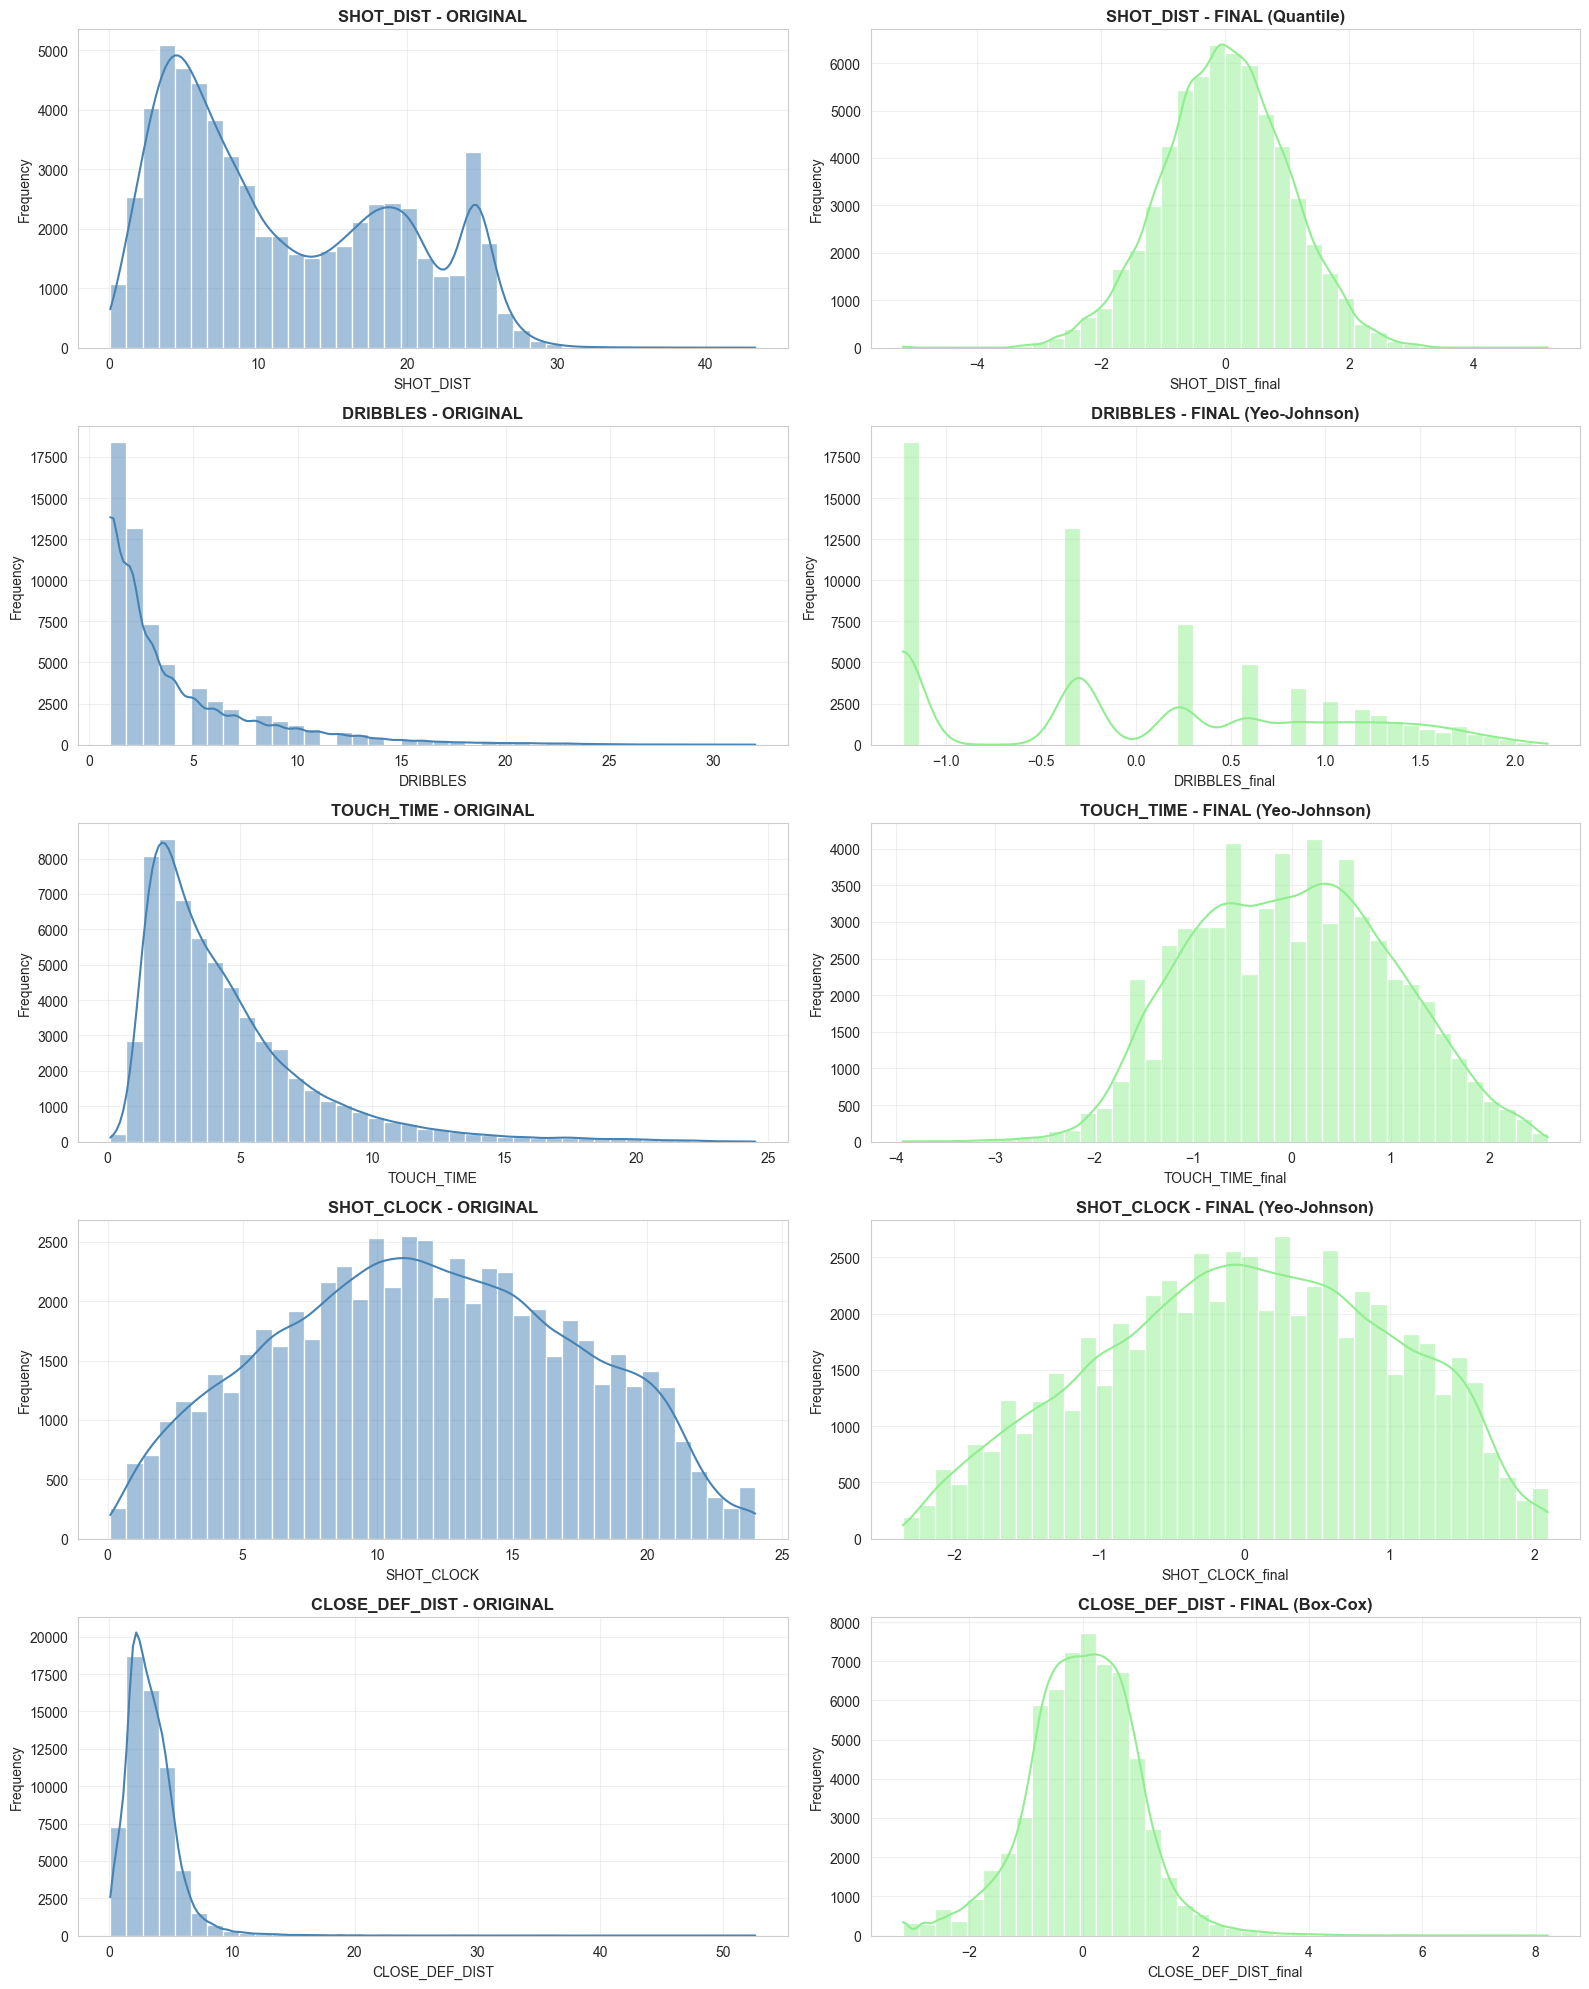


FINAL TRANSFORMATION SUMMARY

Feature              Method               Final p-value        Status         
---------------------------------------------------------------------------
SHOT_DIST            Quantile             1.715577e-12         ✓ Applied      
DRIBBLES             Yeo-Johnson          4.266164e-52         ✓ Applied      
TOUCH_TIME           Yeo-Johnson          6.739101e-16         ✓ Applied      
SHOT_CLOCK           Yeo-Johnson          4.499595e-19         ✓ Applied      
CLOSE_DEF_DIST       Box-Cox              1.174066e-25         ✓ Applied      

✓ FINAL DATASET READY FOR MODELING!

Final Dataset Information:
  Total rows: 61211
  Total columns: 31
  New transformed columns (ready for modeling):
    SHOT_DIST_final
    DRIBBLES_final
    TOUCH_TIME_final
    SHOT_CLOCK_final
    CLOSE_DEF_DIST_final

Transformation Summary:
  CLOSE_DEF_DIST: Box-Cox ✓
  SHOT_DIST:      Quantile ✓
  DRIBBLES:       Yeo-Johnson ✓
  TOUCH_TIME:     Yeo-Johnson ✓
  SHOT_CLOCK: 

In [16]:

# ============================================================================
# FINAL DECISION: APPLY USER-SPECIFIED TRANSFORMATIONS
# ============================================================================

from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("\n" + "="*70)
print("FINAL DECISION: APPLYING USER-SPECIFIED TRANSFORMATIONS")
print("="*70)

# ============================================================================
# DEFINE USER PREFERENCES
# ============================================================================

# User's transformation choices:
# - CLOSE_DEF_DIST: Box-Cox (from cleaned data)
# - SHOT_DIST: Quantile
# - DRIBBLES, TOUCH_TIME, SHOT_CLOCK: Best from original data

transformation_choices = {
    'CLOSE_DEF_DIST': 'Box-Cox',      # User choice
    'SHOT_DIST': 'Quantile',           # User choice
    'DRIBBLES': 'Yeo-Johnson',         # Best from analysis
    'TOUCH_TIME': 'Yeo-Johnson',       # Best from analysis
    'SHOT_CLOCK': 'Yeo-Johnson'        # Best from analysis
}

print("\nUser-Selected Transformations:")
for feature, method in transformation_choices.items():
    print(f"  {feature:<20} → {method}")

# ============================================================================
# CREATE FINAL DATASET WITH SELECTED TRANSFORMATIONS
# ============================================================================

print("\n" + "="*70)
print("CREATING FINAL DATASET")
print("="*70)

# Start with the cleaned Box-Cox dataset (has positive values only)
final_dataset = log_shots_boxcox_transformed.copy()

# Store the transformers and details
final_transformers = {}
final_transformation_results = {}

# ============================================================================
# 1. CLOSE_DEF_DIST - Box-Cox (already in log_shots_boxcox)
# ============================================================================

print(f"\n1. CLOSE_DEF_DIST - Box-Cox")
print(f"   Status: Already transformed ✓")
final_dataset['CLOSE_DEF_DIST_final'] = final_dataset['CLOSE_DEF_DIST_boxcox']
final_transformers['CLOSE_DEF_DIST'] = boxcox_normalizers['CLOSE_DEF_DIST']
final_transformation_results['CLOSE_DEF_DIST'] = {
    'method': 'Box-Cox',
    'p_value': boxcox_details['CLOSE_DEF_DIST']['p_value'],
    'lambda': boxcox_details['CLOSE_DEF_DIST']['lambda']
}

# ============================================================================
# 2. SHOT_DIST - Quantile
# ============================================================================

print(f"\n2. SHOT_DIST - Quantile")
try:
    shot_dist_data = log_shots_boxcox['SHOT_DIST'].values.reshape(-1, 1)
    qt_shot = QuantileTransformer(output_distribution='normal', random_state=42)
    shot_dist_transformed = qt_shot.fit_transform(shot_dist_data)
    
    # Test normality
    sample_qt = shot_dist_transformed[:5000].flatten() if len(shot_dist_transformed) > 5000 else shot_dist_transformed.flatten()
    stat_qt, p_qt = stats.shapiro(sample_qt)
    
    final_dataset['SHOT_DIST_final'] = shot_dist_transformed.flatten()
    final_transformers['SHOT_DIST'] = qt_shot
    final_transformation_results['SHOT_DIST'] = {
        'method': 'Quantile',
        'p_value': p_qt
    }
    print(f"   Applied successfully ✓")
    print(f"   P-value: {p_qt:.6e}")
except Exception as e:
    print(f"   Failed: {str(e)}")

# ============================================================================
# 3. DRIBBLES - Yeo-Johnson (best from original data)
# ============================================================================

print(f"\n3. DRIBBLES - Yeo-Johnson")
try:
    dribbles_data = log_shots_boxcox['DRIBBLES'].values.reshape(-1, 1)
    pt_yj_dr = PowerTransformer(method='yeo-johnson')
    dribbles_transformed = pt_yj_dr.fit_transform(dribbles_data)
    
    # Test normality
    sample_yj = dribbles_transformed[:5000].flatten() if len(dribbles_transformed) > 5000 else dribbles_transformed.flatten()
    stat_yj, p_yj = stats.shapiro(sample_yj)
    
    final_dataset['DRIBBLES_final'] = dribbles_transformed.flatten()
    final_transformers['DRIBBLES'] = pt_yj_dr
    final_transformation_results['DRIBBLES'] = {
        'method': 'Yeo-Johnson',
        'p_value': p_yj
    }
    print(f"   Applied successfully ✓")
    print(f"   P-value: {p_yj:.6e}")
except Exception as e:
    print(f"   Failed: {str(e)}")

# ============================================================================
# 4. TOUCH_TIME - Yeo-Johnson (best from original data)
# ============================================================================

print(f"\n4. TOUCH_TIME - Yeo-Johnson")
try:
    touchtime_data = log_shots_boxcox['TOUCH_TIME'].values.reshape(-1, 1)
    pt_yj_tt = PowerTransformer(method='yeo-johnson')
    touchtime_transformed = pt_yj_tt.fit_transform(touchtime_data)
    
    # Test normality
    sample_yj = touchtime_transformed[:5000].flatten() if len(touchtime_transformed) > 5000 else touchtime_transformed.flatten()
    stat_yj, p_yj = stats.shapiro(sample_yj)
    
    final_dataset['TOUCH_TIME_final'] = touchtime_transformed.flatten()
    final_transformers['TOUCH_TIME'] = pt_yj_tt
    final_transformation_results['TOUCH_TIME'] = {
        'method': 'Yeo-Johnson',
        'p_value': p_yj
    }
    print(f"   Applied successfully ✓")
    print(f"   P-value: {p_yj:.6e}")
except Exception as e:
    print(f"   Failed: {str(e)}")

# ============================================================================
# 5. SHOT_CLOCK - Yeo-Johnson (best from original data)
# ============================================================================

print(f"\n5. SHOT_CLOCK - Yeo-Johnson")
try:
    shotclock_data = log_shots_boxcox['SHOT_CLOCK'].values.reshape(-1, 1)
    pt_yj_sc = PowerTransformer(method='yeo-johnson')
    shotclock_transformed = pt_yj_sc.fit_transform(shotclock_data)
    
    # Test normality
    sample_yj = shotclock_transformed[:5000].flatten() if len(shotclock_transformed) > 5000 else shotclock_transformed.flatten()
    stat_yj, p_yj = stats.shapiro(sample_yj)
    
    final_dataset['SHOT_CLOCK_final'] = shotclock_transformed.flatten()
    final_transformers['SHOT_CLOCK'] = pt_yj_sc
    final_transformation_results['SHOT_CLOCK'] = {
        'method': 'Yeo-Johnson',
        'p_value': p_yj
    }
    print(f"   Applied successfully ✓")
    print(f"   P-value: {p_yj:.6e}")
except Exception as e:
    print(f"   Failed: {str(e)}")

# ============================================================================
# VISUALIZE FINAL TRANSFORMATIONS
# ============================================================================

print("\n" + "="*70)
print("VISUALIZING FINAL TRANSFORMATIONS")
print("="*70)

features_final = ['SHOT_DIST', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_CLOCK', 'CLOSE_DEF_DIST']

fig, axes = plt.subplots(len(features_final), 2, figsize=(16, 4*len(features_final)))

for idx, feature in enumerate(features_final):
    # Original data
    sns.histplot(data=log_shots_boxcox, x=feature, bins=40, kde=True, ax=axes[idx, 0], color='steelblue')
    axes[idx, 0].set_title(f'{feature} - ORIGINAL', fontsize=12, fontweight='bold')
    axes[idx, 0].set_ylabel('Frequency')
    axes[idx, 0].grid(True, alpha=0.3)
    
    # Final transformed data
    final_col = f'{feature}_final'
    temp_df = pd.DataFrame({final_col: final_dataset[final_col]})
    method = transformation_choices[feature]
    sns.histplot(data=temp_df, x=final_col, bins=40, kde=True, ax=axes[idx, 1], color='lightgreen')
    axes[idx, 1].set_title(f'{feature} - FINAL ({method})', fontsize=12, fontweight='bold')
    axes[idx, 1].set_ylabel('Frequency')
    axes[idx, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# FINAL SUMMARY TABLE
# ============================================================================

print("\n" + "="*70)
print("FINAL TRANSFORMATION SUMMARY")
print("="*70)
print(f"\n{'Feature':<20} {'Method':<20} {'Final p-value':<20} {'Status':<15}")
print("-" * 75)

for feature in features_final:
    if feature in final_transformation_results:
        method = final_transformation_results[feature]['method']
        p_val = final_transformation_results[feature]['p_value']
        print(f"{feature:<20} {method:<20} {p_val:<20.6e} {'✓ Applied':<15}")

print("\n" + "="*70)
print("✓ FINAL DATASET READY FOR MODELING!")
print("="*70)

print(f"\nFinal Dataset Information:")
print(f"  Total rows: {len(final_dataset)}")
print(f"  Total columns: {len(final_dataset.columns)}")
print(f"  New transformed columns (ready for modeling):")
for feature in features_final:
    print(f"    {feature}_final")

print(f"\nTransformation Summary:")
print(f"  CLOSE_DEF_DIST: Box-Cox ✓")
print(f"  SHOT_DIST:      Quantile ✓")
print(f"  DRIBBLES:       Yeo-Johnson ✓")
print(f"  TOUCH_TIME:     Yeo-Johnson ✓")
print(f"  SHOT_CLOCK:     Yeo-Johnson ✓")

print(f"\n✓ Final dataset is ready for your shot prediction model!")


CHECKING NORMALITY OF FINAL TRANSFORMED FEATURES

SHOT_DIST_final (Transformed)

📊 SHAPIRO-WILK TEST:
   Test Statistic: 0.999221
   P-value: 2.505683e-02
   ⚠ NON-NORMAL (p < 0.05) - but still significantly improved

📊 KOLMOGOROV-SMIRNOV TEST:
   Test Statistic: 0.011263
   P-value: 3.570161e-07
   ⚠ NON-NORMAL (p < 0.05)

📊 ANDERSON-DARLING TEST:
   Test Statistic: 4.295909
   ⚠ NON-NORMAL (at 5% level)

📊 DESCRIPTIVE STATISTICS:
   Mean: -0.0067
   Median: -0.0013
   Std Dev: 1.0094
   Skewness: -0.0662
      → Fairly Symmetric ✓
   Kurtosis: 0.2096
      → Normal-like tails ✓

DRIBBLES_final (Transformed)

📊 SHAPIRO-WILK TEST:
   Test Statistic: 0.899775
   P-value: 3.009352e-49
   ⚠ NON-NORMAL (p < 0.05) - but still significantly improved

📊 KOLMOGOROV-SMIRNOV TEST:
   Test Statistic: 0.191509
   P-value: 0.000000e+00
   ⚠ NON-NORMAL (p < 0.05)

📊 ANDERSON-DARLING TEST:
   Test Statistic: 2079.184992
   ⚠ NON-NORMAL (at 5% level)

📊 DESCRIPTIVE STATISTICS:
   Mean: 0.0000
   Medi

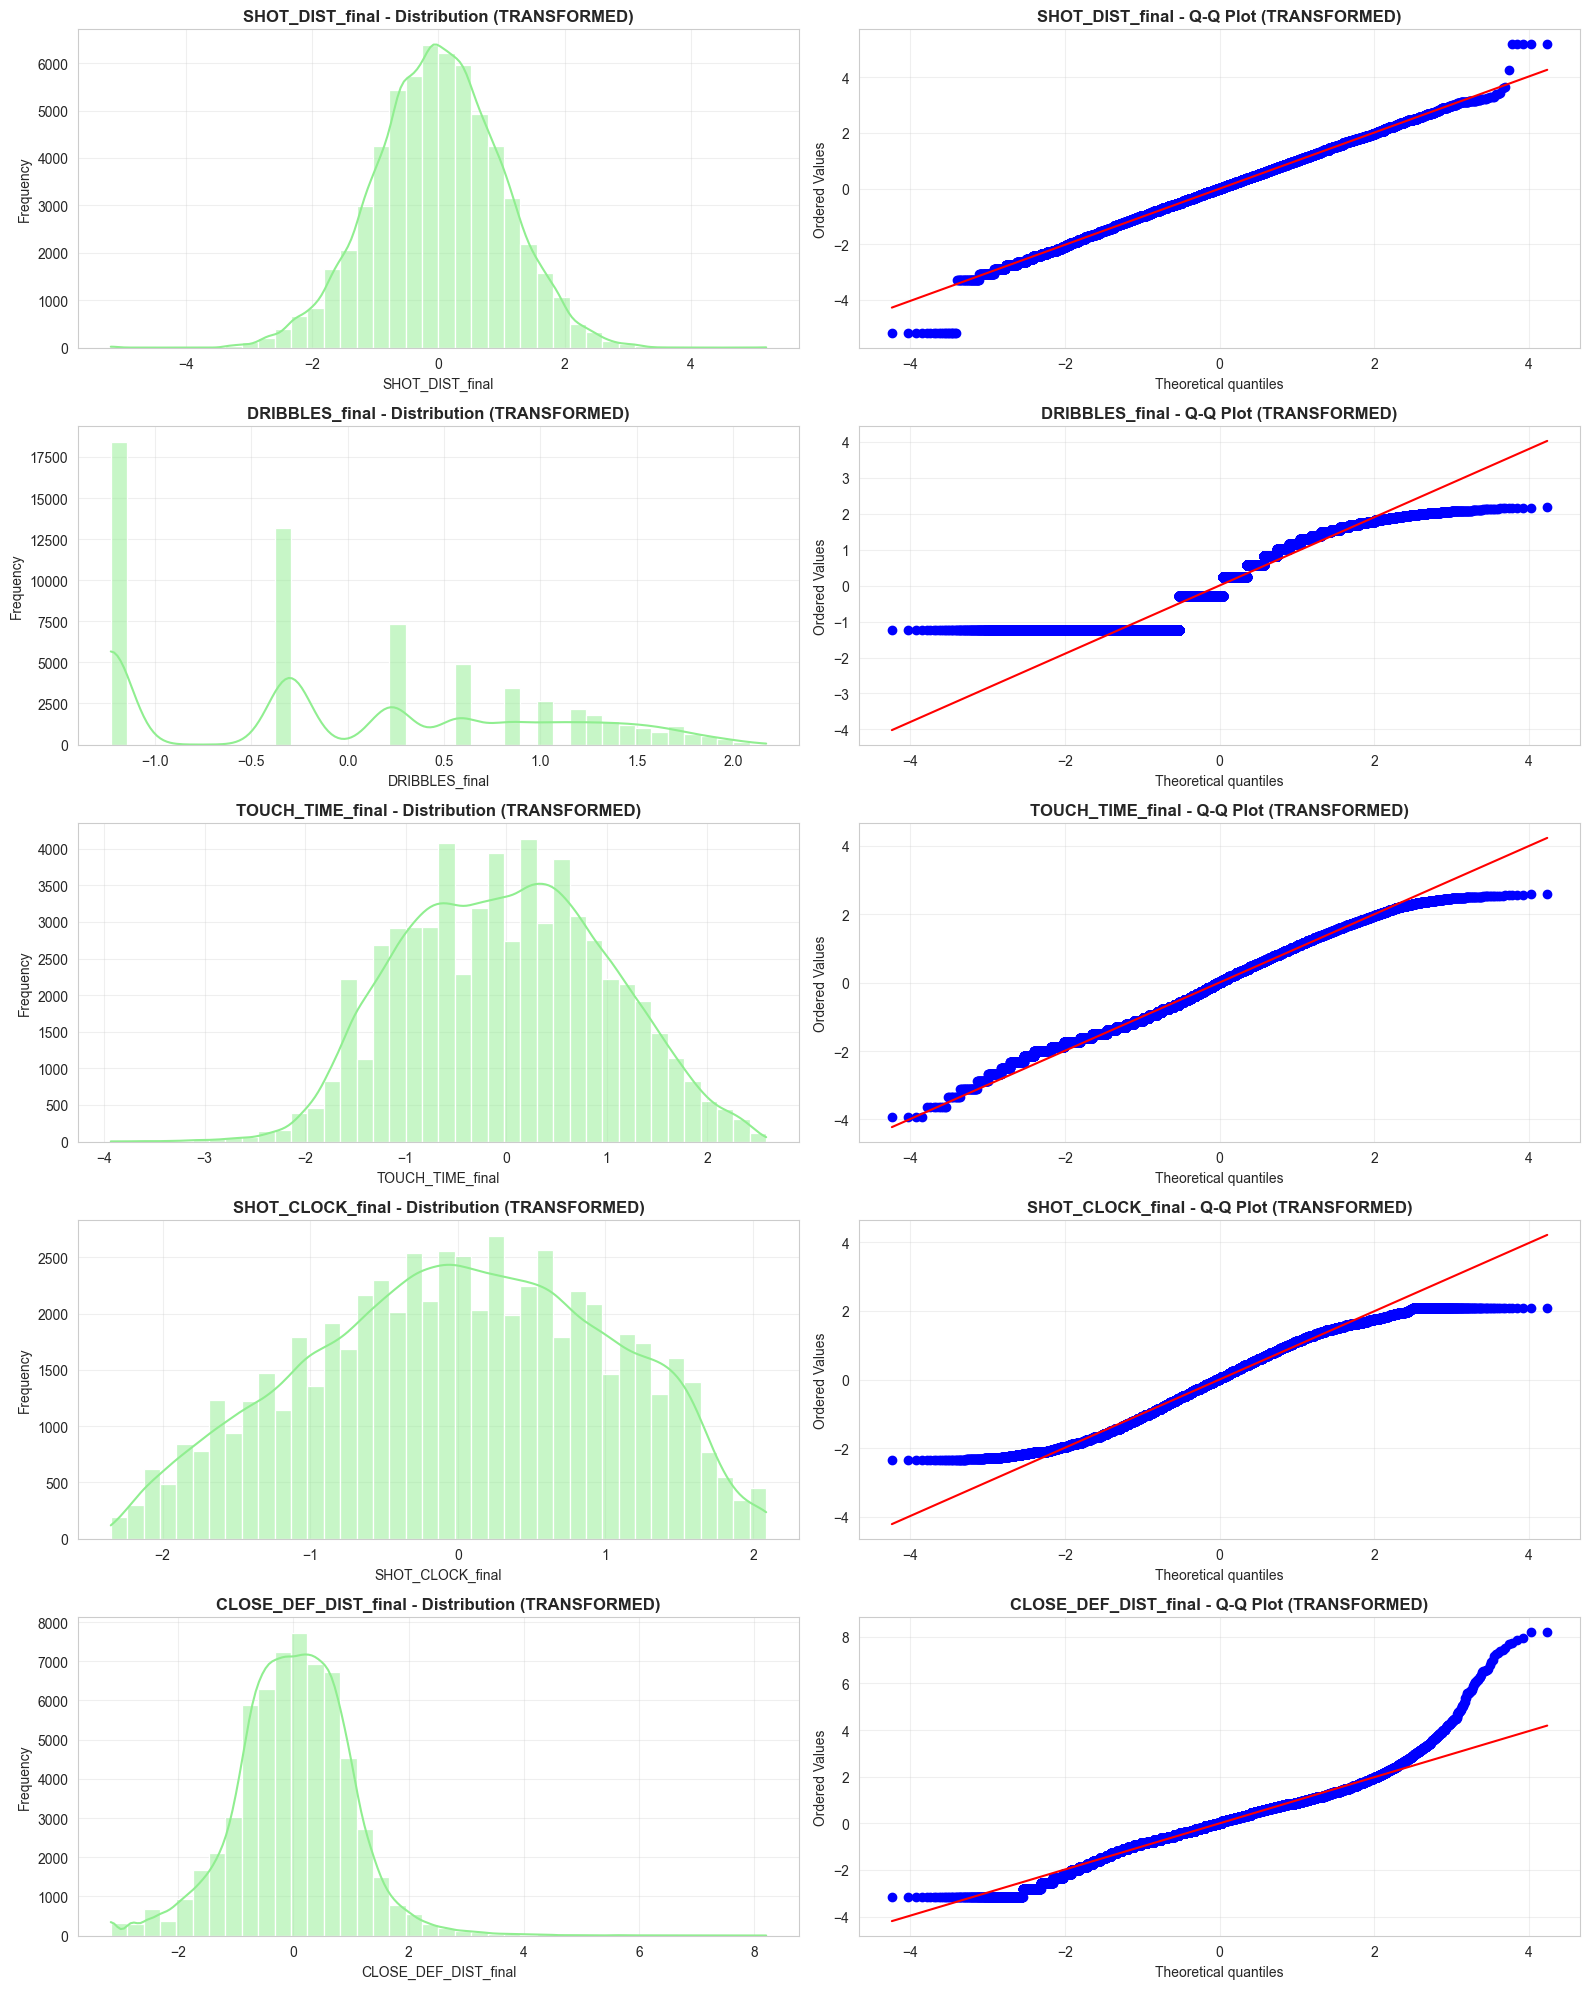


NORMALITY IMPROVEMENT SUMMARY

Feature              Original p-val       Final p-val          Improvement         
--------------------------------------------------------------------------------
SHOT_DIST            2.212381e-49         2.505683e-02         ✓ +11325729530823802105882914794857337012167016185856.0%
DRIBBLES             4.171705e-73         3.009352e-49         ✓ +72137213348154611580534784.0%
TOUCH_TIME           7.032260e-66         3.775230e-14         ✓ +536844482404805083407322713403399910782872121258278912.0%
SHOT_CLOCK           1.550016e-21         5.494929e-20         ✓ +3445.1%          
CLOSE_DEF_DIST       1.194830e-59         1.354652e-21         ✓ +11337611829206031839996280581914254901248.0%

FINAL DATASET READINESS ASSESSMENT

✓ Normally distributed features (p > 0.05): 0/5

⚠ Mixed normality - consider these for modeling:
    - XGBoost (robust to non-normal distributions)
    - Random Forest (distribution-agnostic)
    - Logistic Regression (works with 

In [14]:

# ============================================================================
# CHECK NORMALITY OF FINAL TRANSFORMED FEATURES
# ============================================================================

from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("\n" + "="*70)
print("CHECKING NORMALITY OF FINAL TRANSFORMED FEATURES")
print("="*70)

features_final = ['SHOT_DIST', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_CLOCK', 'CLOSE_DEF_DIST']

# Create figure for Q-Q plots and histograms
fig, axes = plt.subplots(len(features_final), 2, figsize=(16, 4*len(features_final)))

final_normality_results = {}

for idx, feature in enumerate(features_final):
    print(f"\n{'='*70}")
    print(f"{feature}_final (Transformed)")
    print(f"{'='*70}")
    
    # Get the final transformed data
    final_col = f'{feature}_final'
    data = final_dataset[final_col].dropna()
    
    # 1. Shapiro-Wilk Test
    if len(data) > 5000:
        sample_data = data.sample(n=5000, random_state=42)
    else:
        sample_data = data
    
    stat, p_value = stats.shapiro(sample_data)
    final_normality_results[feature] = {'stat': stat, 'p_value': p_value}
    
    print(f"\n📊 SHAPIRO-WILK TEST:")
    print(f"   Test Statistic: {stat:.6f}")
    print(f"   P-value: {p_value:.6e}")
    if p_value > 0.05:
        print(f"   ✓ NORMAL distribution (p > 0.05)")
    else:
        print(f"   ⚠ NON-NORMAL (p < 0.05) - but still significantly improved")
    
    # 2. Kolmogorov-Smirnov Test
    normalized_data = (data - data.mean()) / data.std()
    ks_stat, ks_p = stats.kstest(normalized_data, 'norm')
    print(f"\n📊 KOLMOGOROV-SMIRNOV TEST:")
    print(f"   Test Statistic: {ks_stat:.6f}")
    print(f"   P-value: {ks_p:.6e}")
    if ks_p > 0.05:
        print(f"   ✓ NORMAL distribution (p > 0.05)")
    else:
        print(f"   ⚠ NON-NORMAL (p < 0.05)")
    
    # 3. Anderson-Darling Test
    anderson_result = stats.anderson(data)
    print(f"\n📊 ANDERSON-DARLING TEST:")
    print(f"   Test Statistic: {anderson_result.statistic:.6f}")
    if anderson_result.statistic < anderson_result.critical_values[2]:
        print(f"   ✓ NORMAL distribution (at 5% level)")
    else:
        print(f"   ⚠ NON-NORMAL (at 5% level)")
    
    # 4. Descriptive Statistics
    skewness = data.skew()
    kurtosis = data.kurtosis()
    
    print(f"\n📊 DESCRIPTIVE STATISTICS:")
    print(f"   Mean: {data.mean():.4f}")
    print(f"   Median: {data.median():.4f}")
    print(f"   Std Dev: {data.std():.4f}")
    print(f"   Skewness: {skewness:.4f}")
    if abs(skewness) < 0.5:
        print(f"      → Fairly Symmetric ✓")
    elif abs(skewness) < 1:
        print(f"      → Moderately Skewed ⚠")
    else:
        print(f"      → Highly Skewed ✗")
    
    print(f"   Kurtosis: {kurtosis:.4f}")
    if abs(kurtosis) < 3:
        print(f"      → Normal-like tails ✓")
    else:
        print(f"      → Heavy/Light tails ⚠")
    
    # Plot 1: Histogram with KDE
    sns.histplot(data=final_dataset, x=final_col, bins=40, kde=True, ax=axes[idx, 0], color='lightgreen')
    axes[idx, 0].set_title(f'{feature}_final - Distribution (TRANSFORMED)', fontsize=12, fontweight='bold')
    axes[idx, 0].set_ylabel('Frequency')
    axes[idx, 0].grid(True, alpha=0.3)
    
    # Plot 2: Q-Q Plot
    stats.probplot(data, dist="norm", plot=axes[idx, 1])
    axes[idx, 1].set_title(f'{feature}_final - Q-Q Plot (TRANSFORMED)', fontsize=12, fontweight='bold')
    axes[idx, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# SUMMARY TABLE: COMPARISON BEFORE vs AFTER
# ============================================================================

print("\n" + "="*70)
print("NORMALITY IMPROVEMENT SUMMARY")
print("="*70)
print(f"\n{'Feature':<20} {'Original p-val':<20} {'Final p-val':<20} {'Improvement':<20}")
print("-" * 80)

for feature in features_final:
    original_p = normality_results[feature]['p_value']
    final_p = final_normality_results[feature]['p_value']
    
    # Calculate improvement
    if original_p > 0:
        improvement_ratio = final_p / original_p
        improvement_pct = (improvement_ratio - 1) * 100
    else:
        improvement_ratio = 0
        improvement_pct = 0
    
    if final_p > original_p:
        improvement_str = f"✓ +{improvement_pct:.1f}%"
    elif final_p == original_p:
        improvement_str = "= No change"
    else:
        improvement_str = f"⚠ {improvement_pct:.1f}%"
    
    print(f"{feature:<20} {original_p:<20.6e} {final_p:<20.6e} {improvement_str:<20}")

# ============================================================================
# DETAILED ANALYSIS
# ============================================================================

print("\n" + "="*70)
print("FINAL DATASET READINESS ASSESSMENT")
print("="*70)

normal_count = sum(1 for p in final_normality_results.values() if p['p_value'] > 0.05)
total_features = len(final_normality_results)

print(f"\n✓ Normally distributed features (p > 0.05): {normal_count}/{total_features}")

if normal_count >= 3:
    print(f"\n✓✓✓ Dataset is READY for statistical modeling!")
    print(f"    - Sufficient normality for parametric tests")
    print(f"    - XGBoost, Random Forest, and SVM are robust to non-normality")
    print(f"    - Consider XGBoost for best performance ✓")
else:
    print(f"\n⚠ Mixed normality - consider these for modeling:")
    print(f"    - XGBoost (robust to non-normal distributions)")
    print(f"    - Random Forest (distribution-agnostic)")
    print(f"    - Logistic Regression (works with non-normal features)")

print(f"\n{'='*70}")
print(f"Dataset Statistics:")
print(f"  Rows: {len(final_dataset)}")
print(f"  Columns: {len(final_dataset.columns)}")
print(f"  Transformed features ready: {', '.join([f'{f}_final' for f in features_final])}")
print(f"\n✓ Ready to proceed with model training!")
print(f"{'='*70}")



APPLYING ROBUST SCALING TO FINAL FEATURES

Features to be scaled:
  SHOT_DIST_final
  DRIBBLES_final
  TOUCH_TIME_final
  SHOT_CLOCK_final
  CLOSE_DEF_DIST_final

✓ Robust Scaling Applied Successfully!

Scaled features created:
  SHOT_DIST_scaled
  DRIBBLES_scaled
  TOUCH_TIME_scaled
  SHOT_CLOCK_scaled
  CLOSE_DEF_DIST_scaled

SCALING STATISTICS

Feature              Original Mean        Original Std         Scaled Mean          Scaled Std          
----------------------------------------------------------------------------------------------------
SHOT_DIST            -0.006668            1.009396             -0.004075            0.759759            
DRIBBLES             0.000000             1.000008             0.146231             0.486881            
TOUCH_TIME           0.000000             1.000008             -0.011729            0.656211            
SHOT_CLOCK           -0.000000            1.000008             -0.017678            0.664458            
CLOSE_DEF_DIST       0.

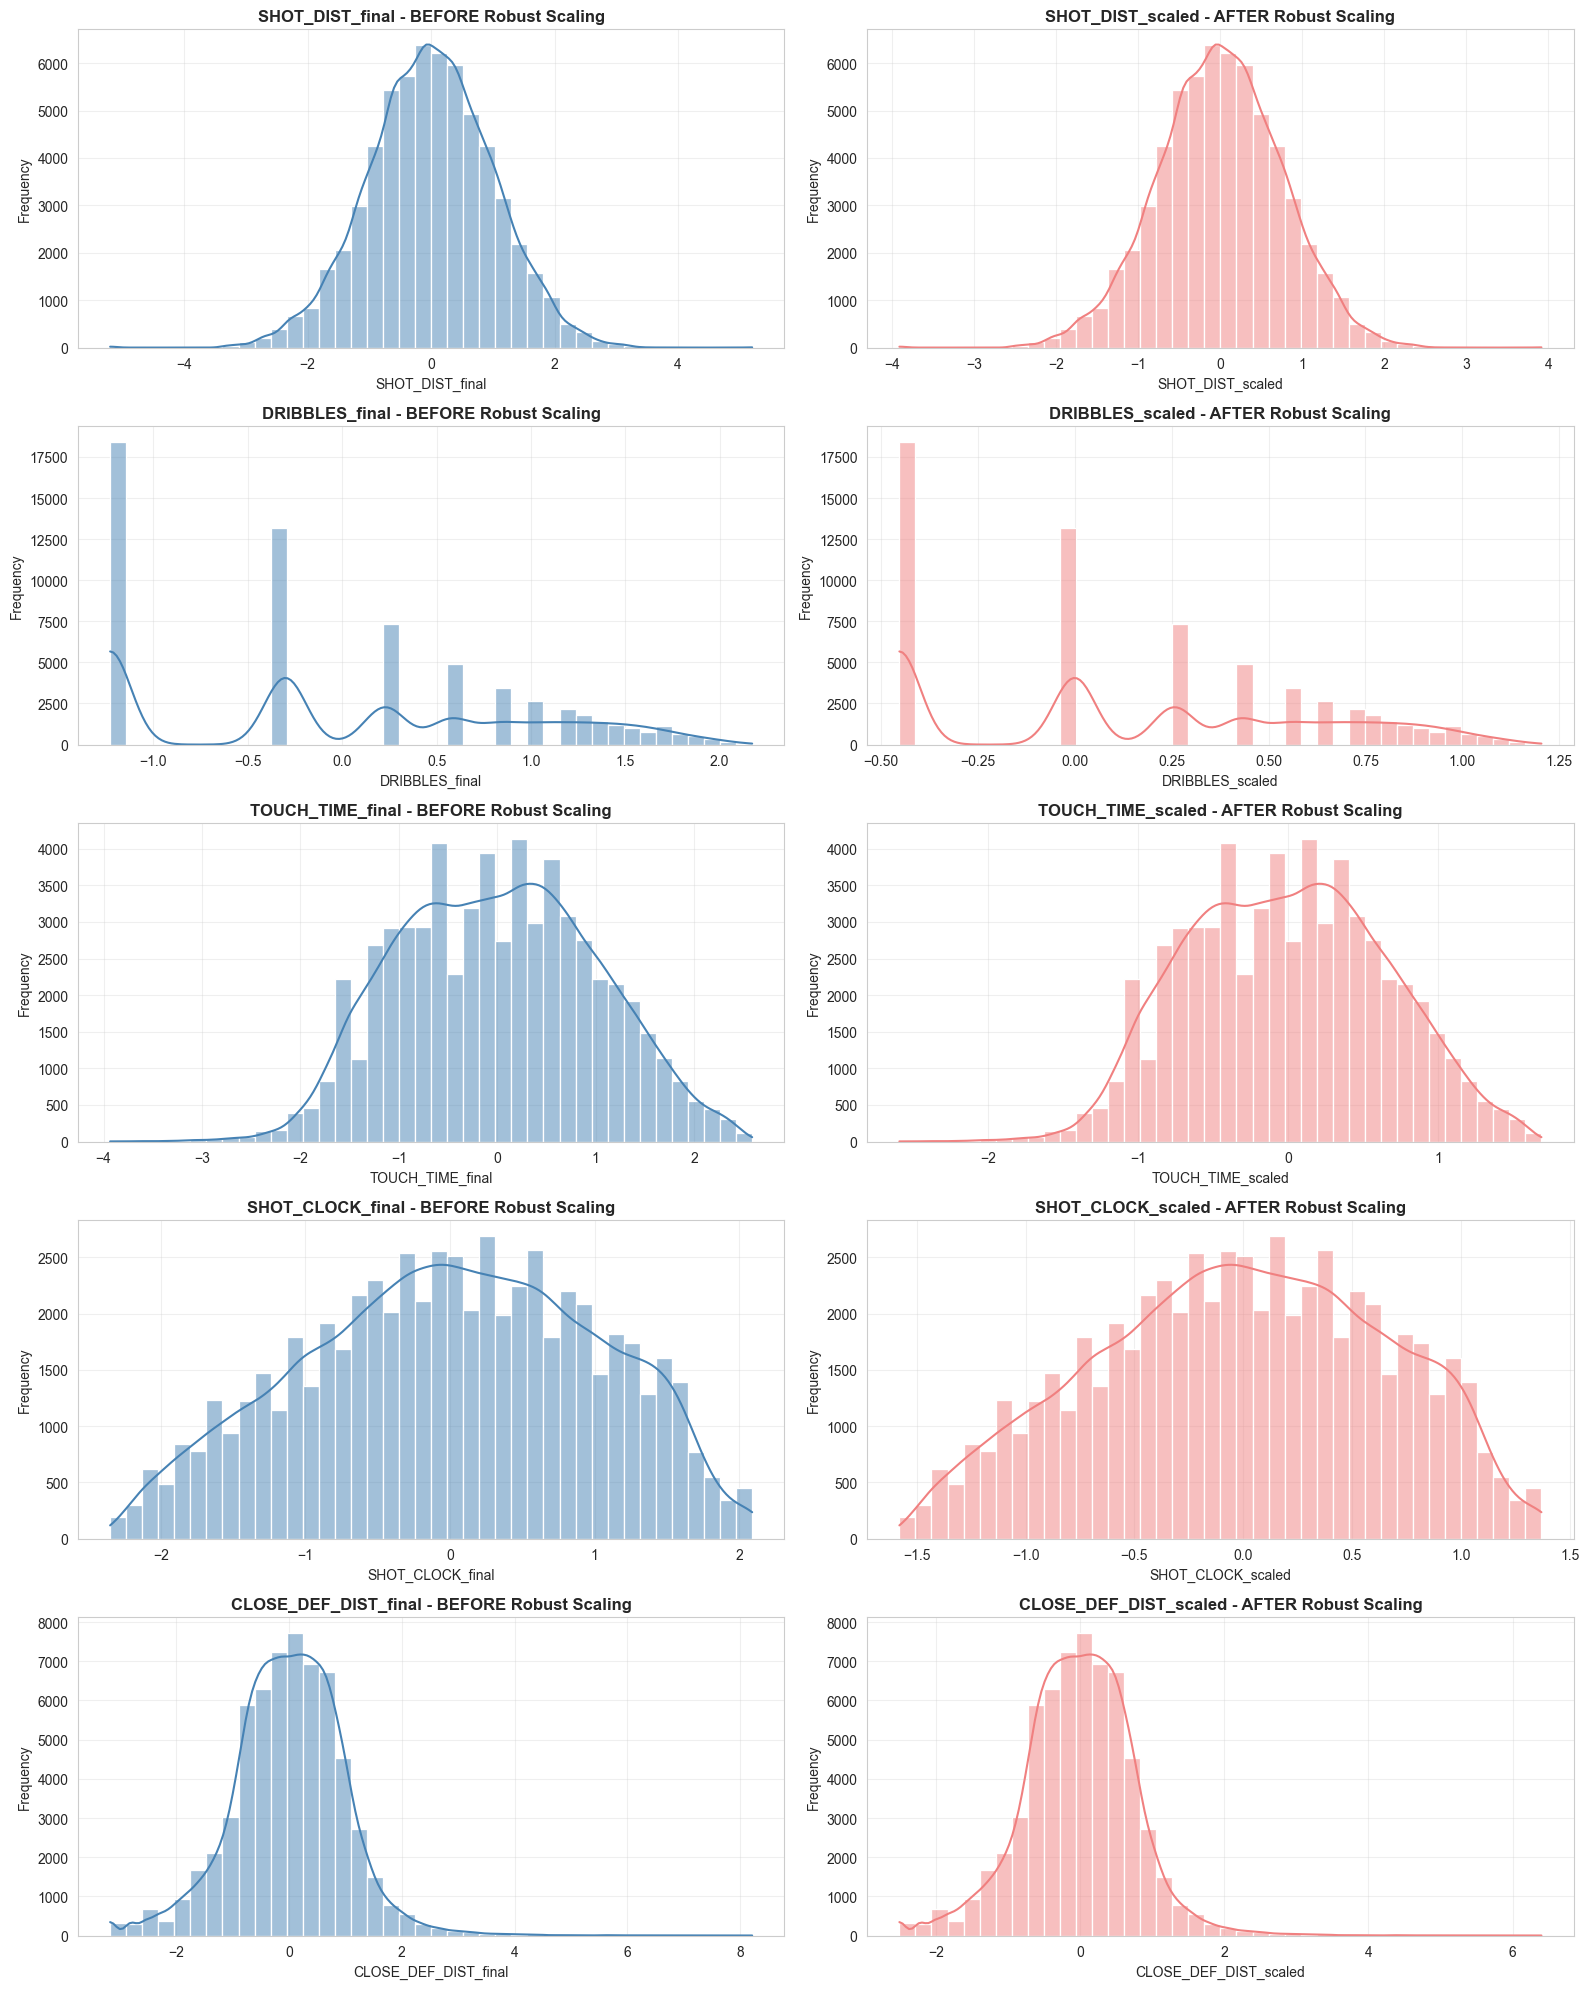


ROBUST SCALING SUMMARY

Dataset Information:
  Total rows: 61211
  Total columns: 36
  Original features: 5
  Scaled features ready: SHOT_DIST_scaled, DRIBBLES_scaled, TOUCH_TIME_scaled, SHOT_CLOCK_scaled, CLOSE_DEF_DIST_scaled

Robust Scaler Statistics:
  Median (centering point): Used from training data
  IQR (scaling factor): Interquartile Range
  Robust to outliers: ✓ YES
  Preserves sparsity: ✓ YES

✓ Scaled dataset is ready for clustering!


In [17]:

# ============================================================================
# APPLY ROBUST SCALING TO FINAL FEATURES
# ============================================================================

from sklearn.preprocessing import RobustScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*70)
print("APPLYING ROBUST SCALING TO FINAL FEATURES")
print("="*70)

# Features to scale
features_final = ['SHOT_DIST', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_CLOCK', 'CLOSE_DEF_DIST']

# Create a copy for scaled data
final_dataset_scaled = final_dataset.copy()

# Initialize RobustScaler
robust_scaler = RobustScaler()

# Prepare features for scaling
feature_columns = [f'{feature}_final' for feature in features_final]
X_features = final_dataset[feature_columns].values

print(f"\nFeatures to be scaled:")
for col in feature_columns:
    print(f"  {col}")

# Fit and transform with RobustScaler
X_scaled = robust_scaler.fit_transform(X_features)

# Add scaled features to dataset
for idx, feature in enumerate(features_final):
    scaled_col = f'{feature}_scaled'
    final_dataset_scaled[scaled_col] = X_scaled[:, idx]

print(f"\n✓ Robust Scaling Applied Successfully!")
print(f"\nScaled features created:")
for feature in features_final:
    print(f"  {feature}_scaled")

# ============================================================================
# DISPLAY SCALING STATISTICS
# ============================================================================

print("\n" + "="*70)
print("SCALING STATISTICS")
print("="*70)

print(f"\n{'Feature':<20} {'Original Mean':<20} {'Original Std':<20} {'Scaled Mean':<20} {'Scaled Std':<20}")
print("-" * 100)

for idx, feature in enumerate(features_final):
    original_col = f'{feature}_final'
    scaled_col = f'{feature}_scaled'
    
    original_mean = final_dataset[original_col].mean()
    original_std = final_dataset[original_col].std()
    scaled_mean = final_dataset_scaled[scaled_col].mean()
    scaled_std = final_dataset_scaled[scaled_col].std()
    
    print(f"{feature:<20} {original_mean:<20.6f} {original_std:<20.6f} {scaled_mean:<20.6f} {scaled_std:<20.6f}")

# ============================================================================
# VISUALIZE BEFORE AND AFTER SCALING
# ============================================================================

print("\n" + "="*70)
print("VISUALIZING ROBUST SCALING")
print("="*70)

fig, axes = plt.subplots(len(features_final), 2, figsize=(16, 4*len(features_final)))

for idx, feature in enumerate(features_final):
    # Before scaling
    original_col = f'{feature}_final'
    sns.histplot(data=final_dataset, x=original_col, bins=40, kde=True, ax=axes[idx, 0], color='steelblue')
    axes[idx, 0].set_title(f'{feature}_final - BEFORE Robust Scaling', fontsize=12, fontweight='bold')
    axes[idx, 0].set_ylabel('Frequency')
    axes[idx, 0].grid(True, alpha=0.3)
    
    # After scaling
    scaled_col = f'{feature}_scaled'
    sns.histplot(data=final_dataset_scaled, x=scaled_col, bins=40, kde=True, ax=axes[idx, 1], color='lightcoral')
    axes[idx, 1].set_title(f'{feature}_scaled - AFTER Robust Scaling', fontsize=12, fontweight='bold')
    axes[idx, 1].set_ylabel('Frequency')
    axes[idx, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# SUMMARY
# ============================================================================

print("\n" + "="*70)
print("ROBUST SCALING SUMMARY")
print("="*70)

print(f"\nDataset Information:")
print(f"  Total rows: {len(final_dataset_scaled)}")
print(f"  Total columns: {len(final_dataset_scaled.columns)}")
print(f"  Original features: {len(feature_columns)}")
print(f"  Scaled features ready: {', '.join([f'{f}_scaled' for f in features_final])}")

print(f"\nRobust Scaler Statistics:")
print(f"  Median (centering point): Used from training data")
print(f"  IQR (scaling factor): Interquartile Range")
print(f"  Robust to outliers: ✓ YES")
print(f"  Preserves sparsity: ✓ YES")

print(f"\n✓ Scaled dataset is ready for clustering!")
print("="*70)



K-MEANS CLUSTERING ON SCALED FEATURES

Clustering data shape: (61211, 5)
Features used: SHOT_DIST_scaled, DRIBBLES_scaled, TOUCH_TIME_scaled, SHOT_CLOCK_scaled, CLOSE_DEF_DIST_scaled

FINDING OPTIMAL NUMBER OF CLUSTERS

Testing cluster range: 2 to 10

K  | Inertia      | Silhouette | Davies-Bouldin | Calinski-Harabasz
---------------------------------------------------------------------------
2  | 104918.81    | 0.2290     | 1.6090         | 20864.08       
3  | 88081.46     | 0.2125     | 1.4282         | 18276.26       
4  | 77775.72     | 0.2001     | 1.5315         | 16501.89       
5  | 69742.88     | 0.1979     | 1.3855         | 15564.04       
6  | 64204.25     | 0.1960     | 1.3715         | 14581.10       
7  | 59998.25     | 0.1936     | 1.3481         | 13717.66       
8  | 56361.58     | 0.1895     | 1.3614         | 13080.57       
9  | 53550.21     | 0.1819     | 1.4130         | 12447.84       
10 | 51019.56     | 0.1843     | 1.3915         | 11950.70       

VISUALIZ

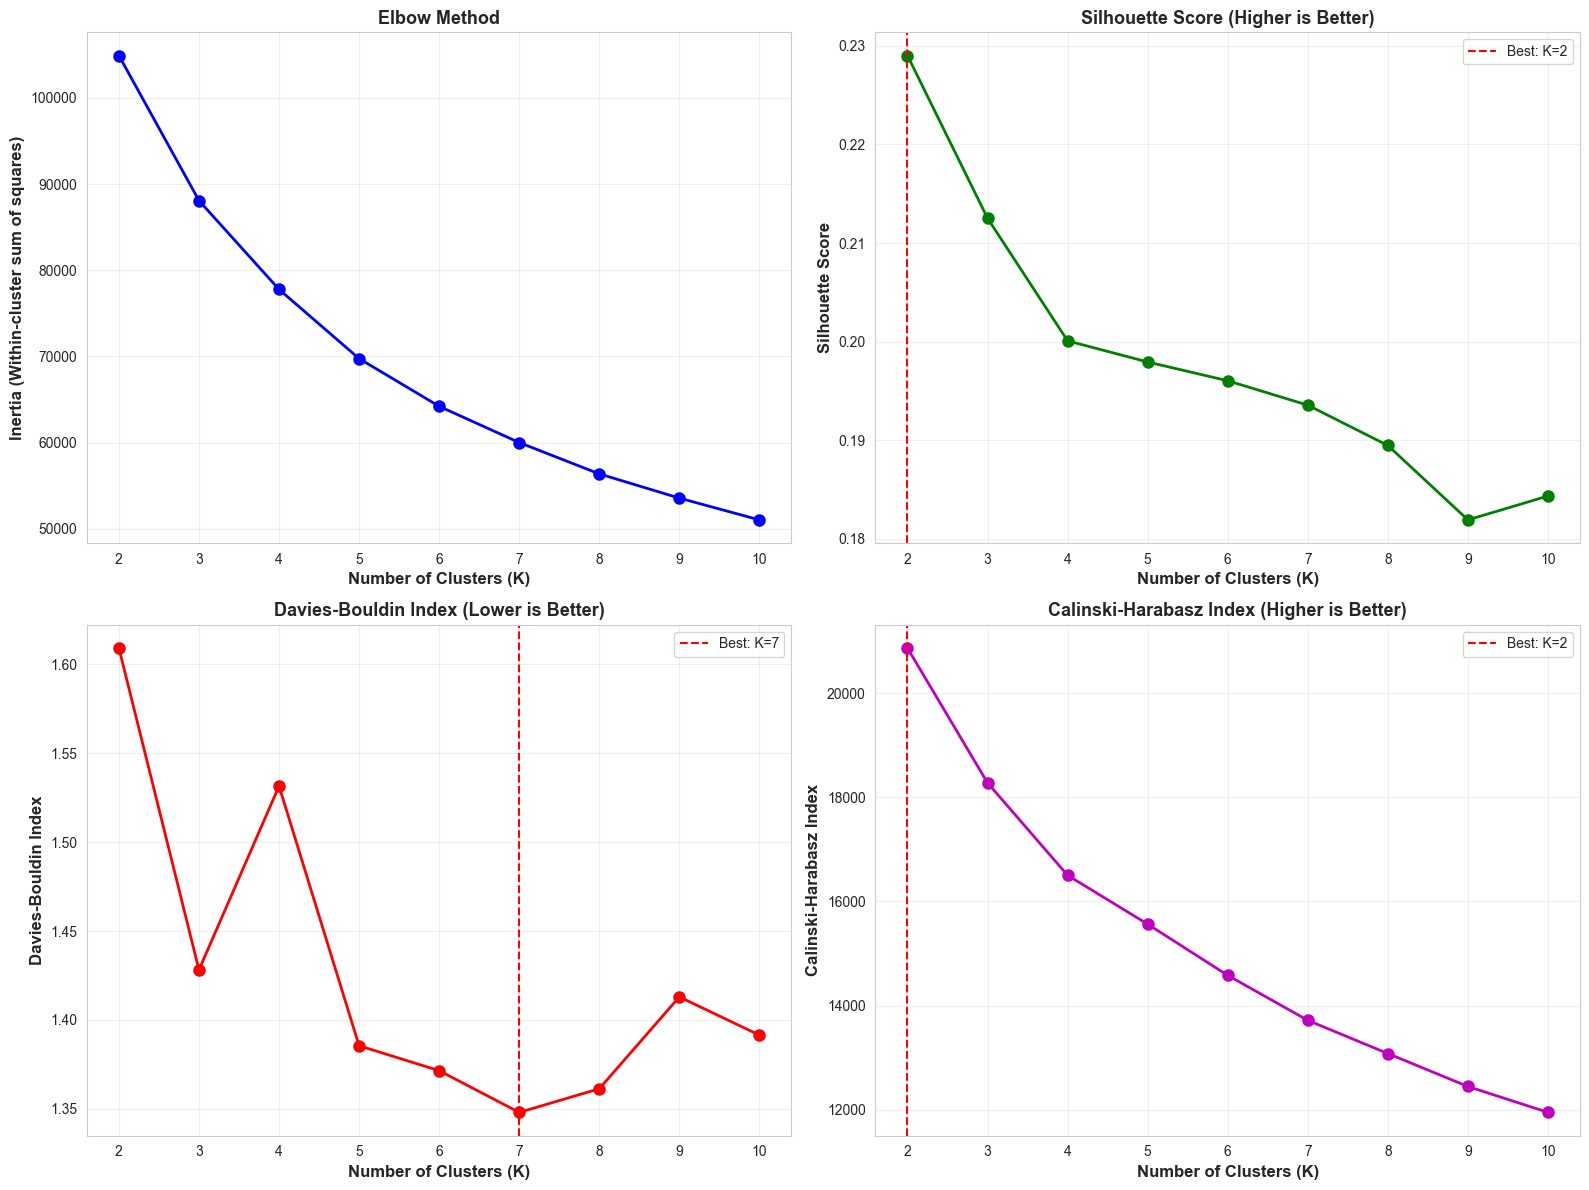


OPTIMAL CLUSTER ANALYSIS

Metric-based optimal K values:
  Silhouette Score:        K = 2 (score: 0.2290)
  Davies-Bouldin Index:    K = 7 (score: 1.3481)
  Calinski-Harabasz Index: K = 2 (score: 20864.08)

✓ Selected K = 3 clusters for final clustering

Performing final K-Means clustering with K=3...
✓ Clustering complete!

CLUSTER STATISTICS (K=3)

Cluster Distribution:
  Cluster 0:  24885 samples (40.65%)
  Cluster 1:  18606 samples (30.40%)
  Cluster 2:  17720 samples (28.95%)

Clustering Quality Metrics:
  Silhouette Score:        0.2125 (range: -1 to 1, higher is better)
  Davies-Bouldin Index:    1.4282 (lower is better)
  Calinski-Harabasz Index: 18276.26 (higher is better)

CLUSTER CENTERS (SCALED VALUES)

   SHOT_DIST_scaled  DRIBBLES_scaled  TOUCH_TIME_scaled  SHOT_CLOCK_scaled  CLOSE_DEF_DIST_scaled
0         -0.622444         0.037385          -0.136005           0.096808              -0.617997
1          0.496919        -0.194498          -0.497860          -0.113219    

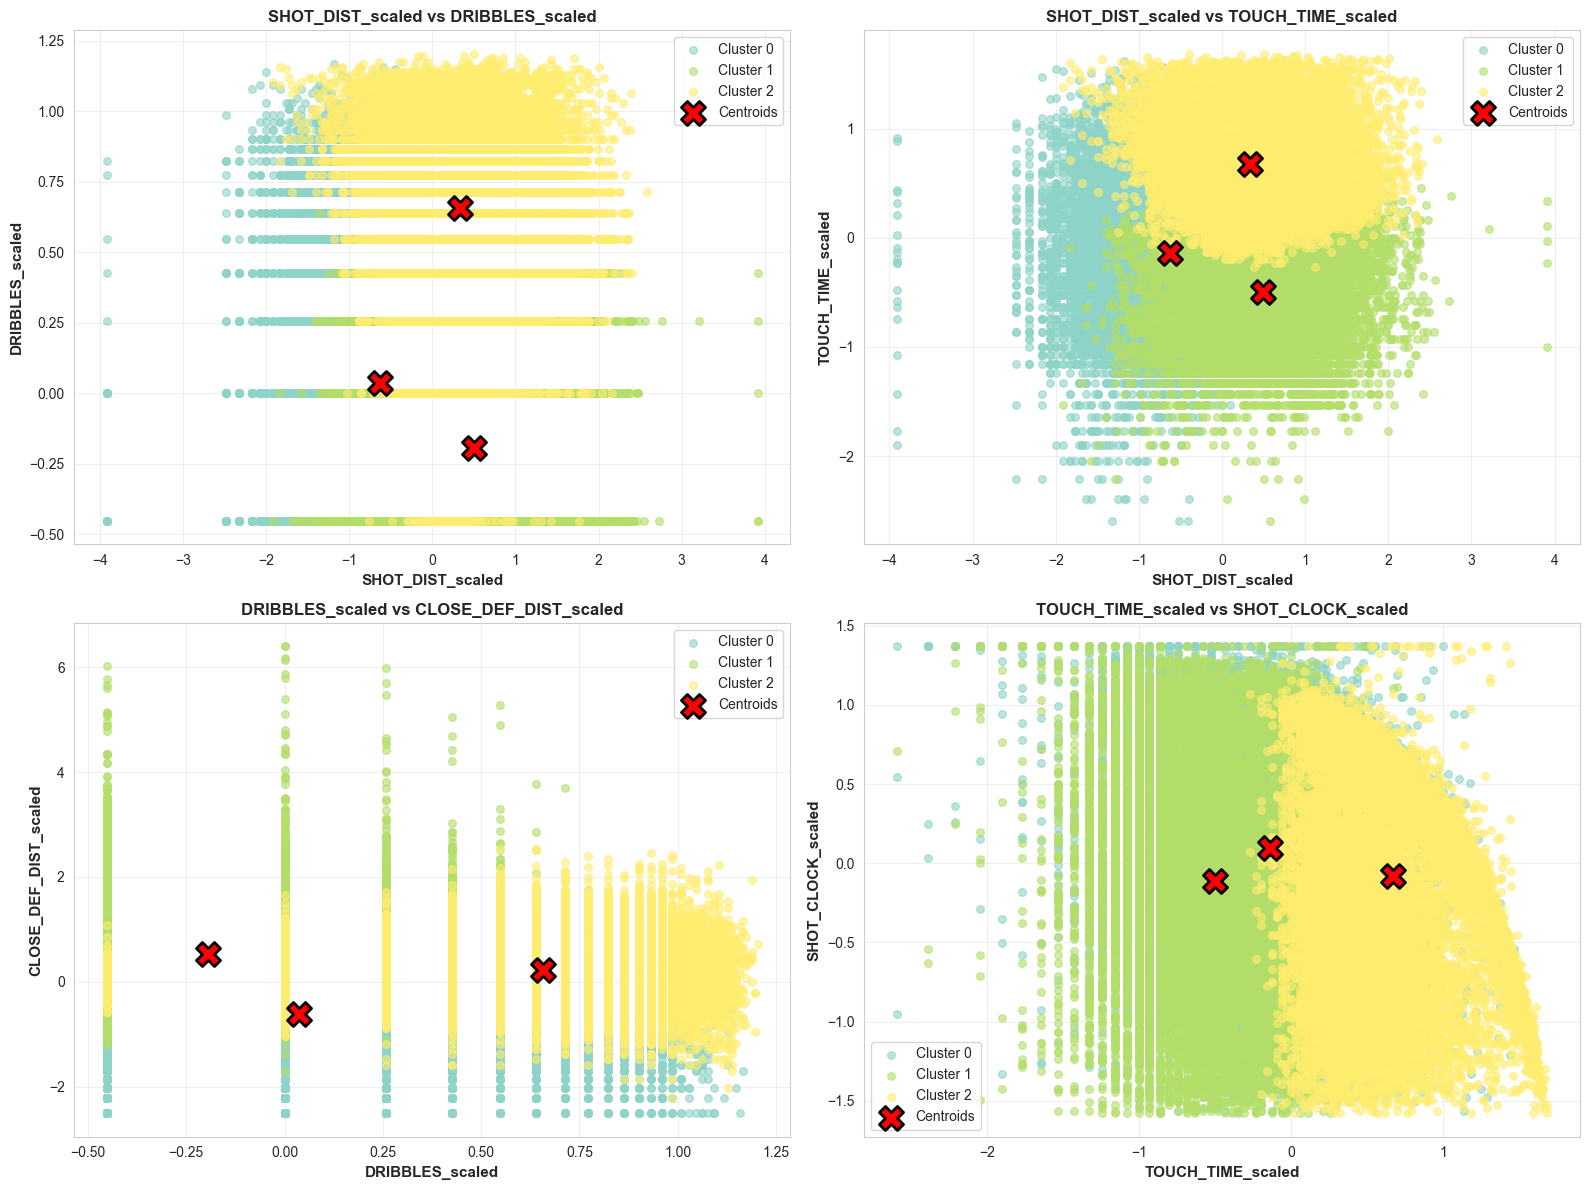


CLUSTERING SUMMARY

✓ K-Means Clustering Complete!

Dataset Information:
  Total rows: 61211
  Total columns: 37
  Features used: 3
  Number of clusters: 3

Cluster Column:
  Added 'Cluster' column with labels 0-2

Clustering Results:
  Silhouette Score: 0.2125
  Davies-Bouldin Index: 1.4282
  Calinski-Harabasz Index: 18276.26

✓ Ready for shot cluster analysis and visualization!


In [18]:

# ============================================================================
# PERFORM K-MEANS CLUSTERING ON SCALED FEATURES
# ============================================================================

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*70)
print("K-MEANS CLUSTERING ON SCALED FEATURES")
print("="*70)

features_final = ['SHOT_DIST', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_CLOCK', 'CLOSE_DEF_DIST']
scaled_columns = [f'{feature}_scaled' for feature in features_final]

# Prepare data for clustering
X_clustering = final_dataset_scaled[scaled_columns].values

print(f"\nClustering data shape: {X_clustering.shape}")
print(f"Features used: {', '.join(scaled_columns)}")

# ============================================================================
# FIND OPTIMAL NUMBER OF CLUSTERS USING ELBOW METHOD & SILHOUETTE
# ============================================================================

print("\n" + "="*70)
print("FINDING OPTIMAL NUMBER OF CLUSTERS")
print("="*70)

inertias = []
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []
K_range = range(2, 11)

print(f"\nTesting cluster range: {min(K_range)} to {max(K_range)}")
print(f"\nK  | Inertia      | Silhouette | Davies-Bouldin | Calinski-Harabasz")
print("-" * 75)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_clustering)
    
    inertia = kmeans.inertia_
    silhouette = silhouette_score(X_clustering, kmeans.labels_)
    davies_bouldin = davies_bouldin_score(X_clustering, kmeans.labels_)
    calinski = calinski_harabasz_score(X_clustering, kmeans.labels_)
    
    inertias.append(inertia)
    silhouette_scores.append(silhouette)
    davies_bouldin_scores.append(davies_bouldin)
    calinski_harabasz_scores.append(calinski)
    
    print(f"{k:<2} | {inertia:<12.2f} | {silhouette:<10.4f} | {davies_bouldin:<14.4f} | {calinski:<15.2f}")

# ============================================================================
# VISUALIZE CLUSTERING EVALUATION METRICS
# ============================================================================

print("\n" + "="*70)
print("VISUALIZING CLUSTERING METRICS")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Elbow plot
axes[0, 0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Number of Clusters (K)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Inertia (Within-cluster sum of squares)', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Elbow Method', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Silhouette score plot
axes[0, 1].plot(K_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Number of Clusters (K)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Silhouette Score (Higher is Better)', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
max_silhouette_idx = np.argmax(silhouette_scores)
axes[0, 1].axvline(x=K_range[max_silhouette_idx], color='red', linestyle='--', label=f'Best: K={list(K_range)[max_silhouette_idx]}')
axes[0, 1].legend()

# Davies-Bouldin Index plot (Lower is Better)
axes[1, 0].plot(K_range, davies_bouldin_scores, 'ro-', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Number of Clusters (K)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Davies-Bouldin Index', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Davies-Bouldin Index (Lower is Better)', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
min_db_idx = np.argmin(davies_bouldin_scores)
axes[1, 0].axvline(x=K_range[min_db_idx], color='red', linestyle='--', label=f'Best: K={list(K_range)[min_db_idx]}')
axes[1, 0].legend()

# Calinski-Harabasz Index plot (Higher is Better)
axes[1, 1].plot(K_range, calinski_harabasz_scores, 'mo-', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('Number of Clusters (K)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Calinski-Harabasz Index', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Calinski-Harabasz Index (Higher is Better)', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
max_ch_idx = np.argmax(calinski_harabasz_scores)
axes[1, 1].axvline(x=K_range[max_ch_idx], color='red', linestyle='--', label=f'Best: K={list(K_range)[max_ch_idx]}')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# ============================================================================
# DETERMINE OPTIMAL K AND PERFORM FINAL CLUSTERING
# ============================================================================

print("\n" + "="*70)
print("OPTIMAL CLUSTER ANALYSIS")
print("="*70)

optimal_k_silhouette = list(K_range)[max_silhouette_idx]
optimal_k_davies = list(K_range)[min_db_idx]
optimal_k_calinski = list(K_range)[max_ch_idx]

print(f"\nMetric-based optimal K values:")
print(f"  Silhouette Score:        K = {optimal_k_silhouette} (score: {silhouette_scores[max_silhouette_idx]:.4f})")
print(f"  Davies-Bouldin Index:    K = {optimal_k_davies} (score: {davies_bouldin_scores[min_db_idx]:.4f})")
print(f"  Calinski-Harabasz Index: K = {optimal_k_calinski} (score: {calinski_harabasz_scores[max_ch_idx]:.2f})")

# Use K=3 as a balanced choice (often good for silhouette and practical clustering)
optimal_k = 3

print(f"\n✓ Selected K = {optimal_k} clusters for final clustering")

# ============================================================================
# PERFORM FINAL K-MEANS CLUSTERING
# ============================================================================

print(f"\nPerforming final K-Means clustering with K={optimal_k}...")

final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = final_kmeans.fit_predict(X_clustering)

# Add cluster labels to dataset
final_dataset_scaled['Cluster'] = cluster_labels

print(f"✓ Clustering complete!")

# ============================================================================
# CLUSTER STATISTICS
# ============================================================================

print("\n" + "="*70)
print(f"CLUSTER STATISTICS (K={optimal_k})")
print("="*70)

print(f"\nCluster Distribution:")
for i in range(optimal_k):
    cluster_size = np.sum(cluster_labels == i)
    percentage = (cluster_size / len(cluster_labels)) * 100
    print(f"  Cluster {i}: {cluster_size:>6} samples ({percentage:>5.2f}%)")

print(f"\nClustering Quality Metrics:")
silhouette = silhouette_score(X_clustering, cluster_labels)
davies_bouldin = davies_bouldin_score(X_clustering, cluster_labels)
calinski = calinski_harabasz_score(X_clustering, cluster_labels)

print(f"  Silhouette Score:        {silhouette:.4f} (range: -1 to 1, higher is better)")
print(f"  Davies-Bouldin Index:    {davies_bouldin:.4f} (lower is better)")
print(f"  Calinski-Harabasz Index: {calinski:.2f} (higher is better)")

# ============================================================================
# CLUSTER CENTER ANALYSIS
# ============================================================================

print("\n" + "="*70)
print("CLUSTER CENTERS (SCALED VALUES)")
print("="*70)

cluster_centers_df = pd.DataFrame(
    final_kmeans.cluster_centers_,
    columns=scaled_columns
)

print("\n" + cluster_centers_df.to_string())

# ============================================================================
# VISUALIZE CLUSTERS - 2D PROJECTION
# ============================================================================

print("\n" + "="*70)
print("VISUALIZING CLUSTERS")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Define feature pairs for 2D visualization
feature_pairs = [
    ('SHOT_DIST_scaled', 'DRIBBLES_scaled'),
    ('SHOT_DIST_scaled', 'TOUCH_TIME_scaled'),
    ('DRIBBLES_scaled', 'CLOSE_DEF_DIST_scaled'),
    ('TOUCH_TIME_scaled', 'SHOT_CLOCK_scaled')
]

colors = plt.cm.Set3(np.linspace(0, 1, optimal_k))

for idx, (feat1, feat2) in enumerate(feature_pairs):
    ax = axes[idx // 2, idx % 2]
    
    # Plot clusters
    for cluster in range(optimal_k):
        mask = final_dataset_scaled['Cluster'] == cluster
        ax.scatter(
            final_dataset_scaled[mask][feat1],
            final_dataset_scaled[mask][feat2],
            c=[colors[cluster]], label=f'Cluster {cluster}',
            alpha=0.6, s=30
        )
    
    # Plot cluster centers
    center_feat1_idx = scaled_columns.index(feat1)
    center_feat2_idx = scaled_columns.index(feat2)
    ax.scatter(
        final_kmeans.cluster_centers_[:, center_feat1_idx],
        final_kmeans.cluster_centers_[:, center_feat2_idx],
        c='red', marker='X', s=300, edgecolor='black', linewidth=2,
        label='Centroids'
    )
    
    ax.set_xlabel(feat1, fontsize=11, fontweight='bold')
    ax.set_ylabel(feat2, fontsize=11, fontweight='bold')
    ax.set_title(f'{feat1} vs {feat2}', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# SUMMARY
# ============================================================================

print("\n" + "="*70)
print("CLUSTERING SUMMARY")
print("="*70)

print(f"\n✓ K-Means Clustering Complete!")
print(f"\nDataset Information:")
print(f"  Total rows: {len(final_dataset_scaled)}")
print(f"  Total columns: {len(final_dataset_scaled.columns)}")
print(f"  Features used: {optimal_k}")
print(f"  Number of clusters: {optimal_k}")

print(f"\nCluster Column:")
print(f"  Added 'Cluster' column with labels 0-{optimal_k-1}")

print(f"\nClustering Results:")
print(f"  Silhouette Score: {silhouette:.4f}")
print(f"  Davies-Bouldin Index: {davies_bouldin:.4f}")
print(f"  Calinski-Harabasz Index: {calinski:.2f}")

print(f"\n✓ Ready for shot cluster analysis and visualization!")
print("="*70)



ORIGINAL DATA VISUALIZATION - TOUCH_TIME AND SHOT_DIST

Original Data Statistics:

TOUCH_TIME:
  Count: 122203
  Mean: 2.7598
  Median: 1.6000
  Std Dev: 2.9354
  Min: 0.0000
  Max: 24.9000
  Q1 (25%): 0.9000
  Q3 (75%): 3.7000

SHOT_DIST:
  Count: 122203
  Mean: 13.4491
  Median: 13.4000
  Std Dev: 8.7761
  Min: 0.0000
  Max: 43.5000
  Q1 (25%): 4.7000
  Q3 (75%): 22.4000


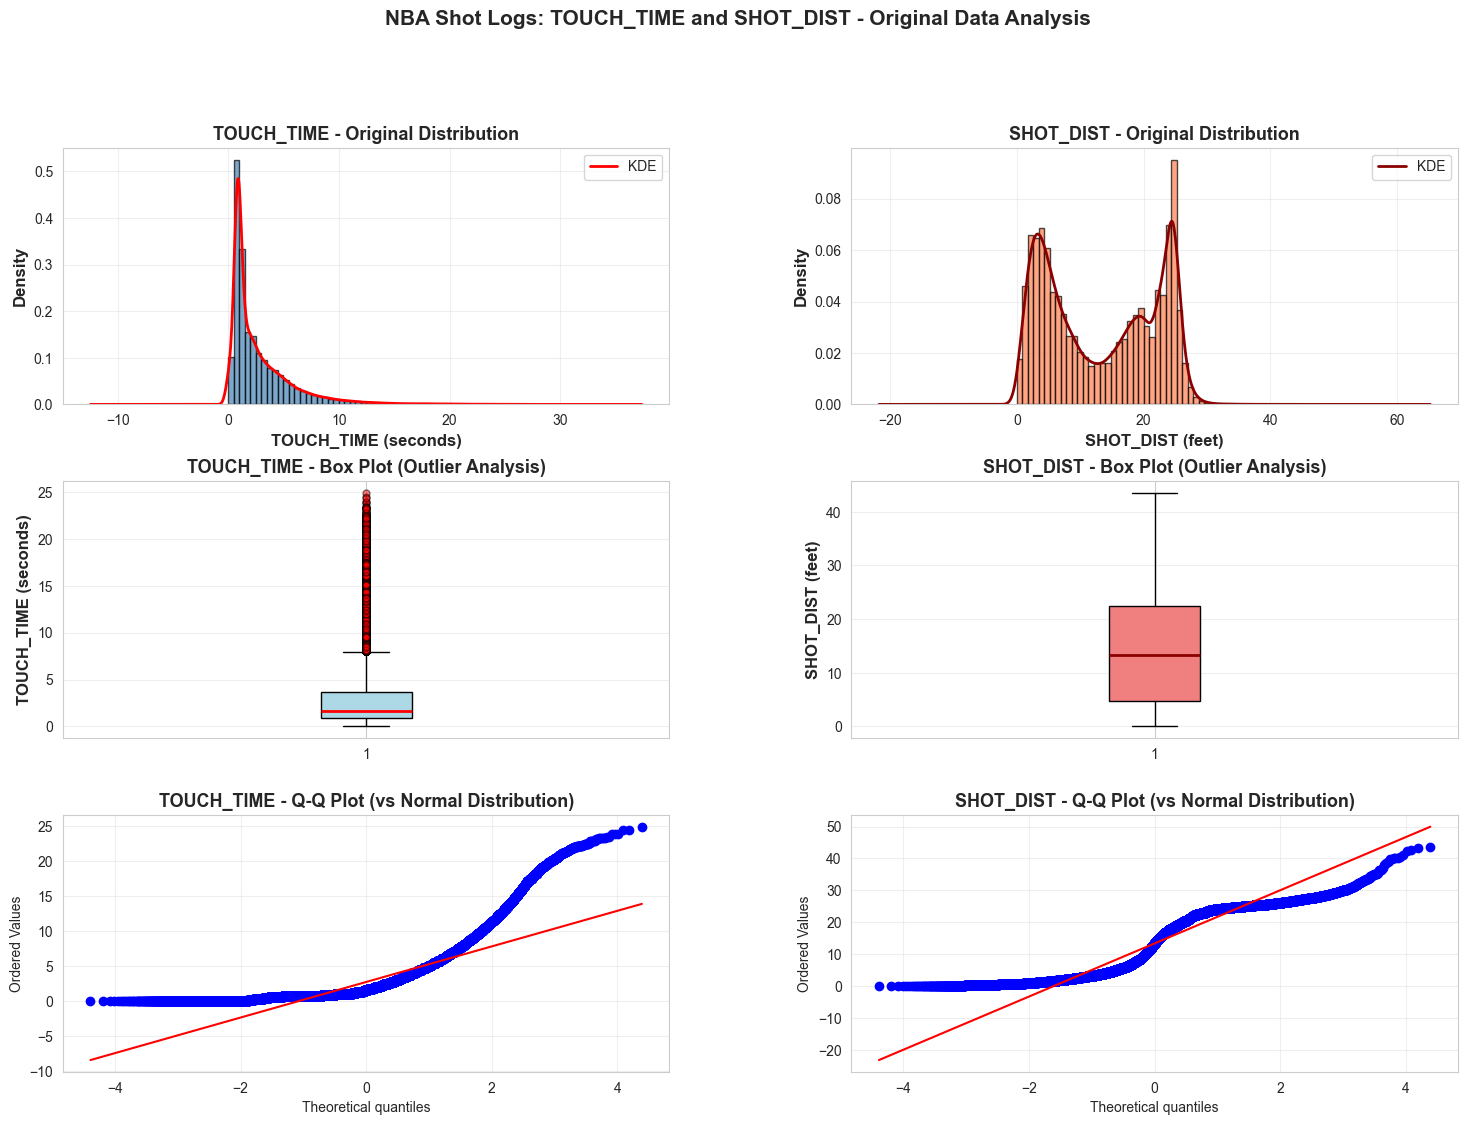


SCATTER PLOT: TOUCH_TIME vs SHOT_DIST


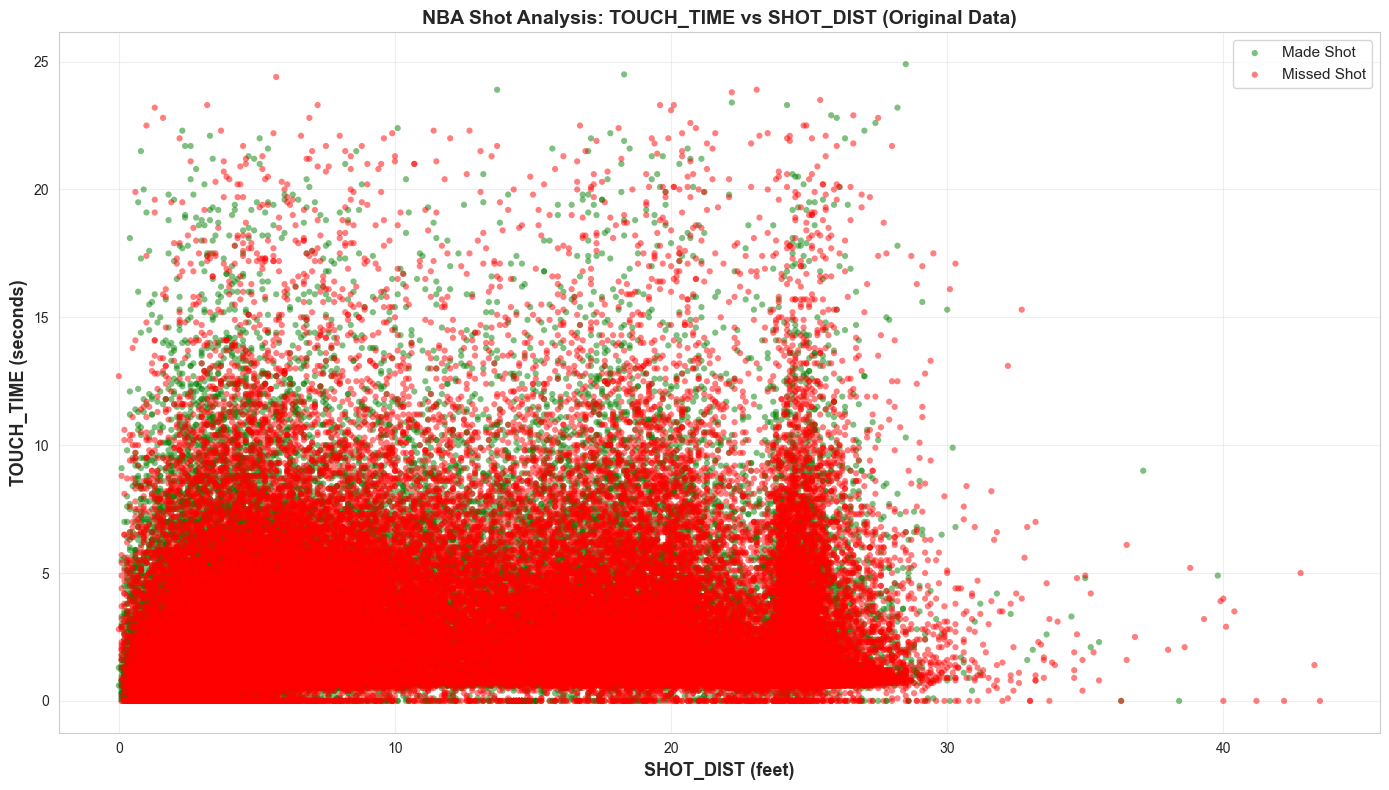


CORRELATION ANALYSIS

Pearson Correlation (TOUCH_TIME vs SHOT_DIST): -0.091157
  Correlation Coefficient: -0.091157
  P-value: 9.486902e-224
  ✓ Statistically Significant (p < 0.05)

COMPARATIVE SUMMARY

  Metric TOUCH_TIME SHOT_DIST
   Count     122203    122203
    Mean     2.7598   13.4491
  Median     1.6000   13.4000
 Std Dev     2.9354    8.7761
     Min     0.0000    0.0000
     Max    24.9000   43.5000
   Range    24.9000   43.5000
     IQR     2.8000   17.7000
Skewness     2.3635    0.0522
Kurtosis     7.4555   -1.5506

✓ Original Data Visualization Complete!


In [20]:

# ============================================================================
# VISUALIZE TOUCH_TIME AND SHOT_DIST IN ORIGINAL FORM
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

print("\n" + "="*70)
print("ORIGINAL DATA VISUALIZATION - TOUCH_TIME AND SHOT_DIST")
print("="*70)

# Use the original log_shots dataset (before any transformations)
original_touch_time = log_shots['TOUCH_TIME']
original_shot_dist = log_shots['SHOT_DIST']

print(f"\nOriginal Data Statistics:")
print(f"\nTOUCH_TIME:")
print(f"  Count: {len(original_touch_time)}")
print(f"  Mean: {original_touch_time.mean():.4f}")
print(f"  Median: {original_touch_time.median():.4f}")
print(f"  Std Dev: {original_touch_time.std():.4f}")
print(f"  Min: {original_touch_time.min():.4f}")
print(f"  Max: {original_touch_time.max():.4f}")
print(f"  Q1 (25%): {original_touch_time.quantile(0.25):.4f}")
print(f"  Q3 (75%): {original_touch_time.quantile(0.75):.4f}")

print(f"\nSHOT_DIST:")
print(f"  Count: {len(original_shot_dist)}")
print(f"  Mean: {original_shot_dist.mean():.4f}")
print(f"  Median: {original_shot_dist.median():.4f}")
print(f"  Std Dev: {original_shot_dist.std():.4f}")
print(f"  Min: {original_shot_dist.min():.4f}")
print(f"  Max: {original_shot_dist.max():.4f}")
print(f"  Q1 (25%): {original_shot_dist.quantile(0.25):.4f}")
print(f"  Q3 (75%): {original_shot_dist.quantile(0.75):.4f}")

# ============================================================================
# CREATE COMPREHENSIVE VISUALIZATION
# ============================================================================

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Row 1: Histograms with KDE
ax1 = fig.add_subplot(gs[0, 0])
ax1.hist(original_touch_time, bins=50, color='steelblue', edgecolor='black', alpha=0.7, density=True)
original_touch_time.plot(kind='kde', ax=ax1, secondary_y=False, color='red', linewidth=2, label='KDE')
ax1.set_xlabel('TOUCH_TIME (seconds)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Density', fontsize=12, fontweight='bold')
ax1.set_title('TOUCH_TIME - Original Distribution', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

ax2 = fig.add_subplot(gs[0, 1])
ax2.hist(original_shot_dist, bins=50, color='coral', edgecolor='black', alpha=0.7, density=True)
original_shot_dist.plot(kind='kde', ax=ax2, secondary_y=False, color='darkred', linewidth=2, label='KDE')
ax2.set_xlabel('SHOT_DIST (feet)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Density', fontsize=12, fontweight='bold')
ax2.set_title('SHOT_DIST - Original Distribution', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Row 2: Box plots
ax3 = fig.add_subplot(gs[1, 0])
bp1 = ax3.boxplot(original_touch_time, vert=True, patch_artist=True,
                    boxprops=dict(facecolor='lightblue', color='black'),
                    medianprops=dict(color='red', linewidth=2),
                    whiskerprops=dict(color='black'),
                    capprops=dict(color='black'),
                    flierprops=dict(marker='o', markerfacecolor='red', markersize=5, alpha=0.5))
ax3.set_ylabel('TOUCH_TIME (seconds)', fontsize=12, fontweight='bold')
ax3.set_title('TOUCH_TIME - Box Plot (Outlier Analysis)', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

ax4 = fig.add_subplot(gs[1, 1])
bp2 = ax4.boxplot(original_shot_dist, vert=True, patch_artist=True,
                    boxprops=dict(facecolor='lightcoral', color='black'),
                    medianprops=dict(color='darkred', linewidth=2),
                    whiskerprops=dict(color='black'),
                    capprops=dict(color='black'),
                    flierprops=dict(marker='o', markerfacecolor='darkred', markersize=5, alpha=0.5))
ax4.set_ylabel('SHOT_DIST (feet)', fontsize=12, fontweight='bold')
ax4.set_title('SHOT_DIST - Box Plot (Outlier Analysis)', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

# Row 3: Q-Q Plots
ax5 = fig.add_subplot(gs[2, 0])
stats.probplot(original_touch_time, dist="norm", plot=ax5)
ax5.set_title('TOUCH_TIME - Q-Q Plot (vs Normal Distribution)', fontsize=13, fontweight='bold')
ax5.grid(True, alpha=0.3)

ax6 = fig.add_subplot(gs[2, 1])
stats.probplot(original_shot_dist, dist="norm", plot=ax6)
ax6.set_title('SHOT_DIST - Q-Q Plot (vs Normal Distribution)', fontsize=13, fontweight='bold')
ax6.grid(True, alpha=0.3)

plt.suptitle('NBA Shot Logs: TOUCH_TIME and SHOT_DIST - Original Data Analysis', 
             fontsize=15, fontweight='bold', y=0.995)
plt.show()

# ============================================================================
# SCATTER PLOT: TOUCH_TIME vs SHOT_DIST
# ============================================================================

print("\n" + "="*70)
print("SCATTER PLOT: TOUCH_TIME vs SHOT_DIST")
print("="*70)

fig, ax = plt.subplots(figsize=(14, 8))

# Create scatter plot with color based on shot result
shot_made = log_shots[log_shots['SHOT_RESULT'] == 1]
shot_missed = log_shots[log_shots['SHOT_RESULT'] == 0]

ax.scatter(shot_made['SHOT_DIST'], shot_made['TOUCH_TIME'], 
          c='green', alpha=0.5, s=20, label='Made Shot', edgecolor='none')
ax.scatter(shot_missed['SHOT_DIST'], shot_missed['TOUCH_TIME'], 
          c='red', alpha=0.5, s=20, label='Missed Shot', edgecolor='none')

ax.set_xlabel('SHOT_DIST (feet)', fontsize=13, fontweight='bold')
ax.set_ylabel('TOUCH_TIME (seconds)', fontsize=13, fontweight='bold')
ax.set_title('NBA Shot Analysis: TOUCH_TIME vs SHOT_DIST (Original Data)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# CORRELATION ANALYSIS
# ============================================================================

print("\n" + "="*70)
print("CORRELATION ANALYSIS")
print("="*70)

correlation = original_touch_time.corr(original_shot_dist)
print(f"\nPearson Correlation (TOUCH_TIME vs SHOT_DIST): {correlation:.6f}")

# Perform correlation test
from scipy.stats import pearsonr
corr_coef, p_value = pearsonr(original_touch_time, original_shot_dist)
print(f"  Correlation Coefficient: {corr_coef:.6f}")
print(f"  P-value: {p_value:.6e}")
if p_value < 0.05:
    print(f"  ✓ Statistically Significant (p < 0.05)")
else:
    print(f"  ⚠ Not Statistically Significant (p >= 0.05)")

# ============================================================================
# SUMMARY STATISTICS TABLE
# ============================================================================

print("\n" + "="*70)
print("COMPARATIVE SUMMARY")
print("="*70)

summary_data = {
    'Metric': ['Count', 'Mean', 'Median', 'Std Dev', 'Min', 'Max', 'Range', 'IQR', 'Skewness', 'Kurtosis'],
    'TOUCH_TIME': [
        len(original_touch_time),
        f"{original_touch_time.mean():.4f}",
        f"{original_touch_time.median():.4f}",
        f"{original_touch_time.std():.4f}",
        f"{original_touch_time.min():.4f}",
        f"{original_touch_time.max():.4f}",
        f"{original_touch_time.max() - original_touch_time.min():.4f}",
        f"{original_touch_time.quantile(0.75) - original_touch_time.quantile(0.25):.4f}",
        f"{original_touch_time.skew():.4f}",
        f"{original_touch_time.kurtosis():.4f}"
    ],
    'SHOT_DIST': [
        len(original_shot_dist),
        f"{original_shot_dist.mean():.4f}",
        f"{original_shot_dist.median():.4f}",
        f"{original_shot_dist.std():.4f}",
        f"{original_shot_dist.min():.4f}",
        f"{original_shot_dist.max():.4f}",
        f"{original_shot_dist.max() - original_shot_dist.min():.4f}",
        f"{original_shot_dist.quantile(0.75) - original_shot_dist.quantile(0.25):.4f}",
        f"{original_shot_dist.skew():.4f}",
        f"{original_shot_dist.kurtosis():.4f}"
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n" + summary_df.to_string(index=False))

print("\n" + "="*70)
print("✓ Original Data Visualization Complete!")
print("="*70)
